#1.Import data from github

In [2]:
!wget https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-01-10/PFW_2021_public.csv
!wget https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-01-10/PFW_count_site_data_public_2021.csv

--2026-02-17 23:37:56--  https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-01-10/PFW_2021_public.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14704853 (14M) [text/plain]
Saving to: ‘PFW_2021_public.csv’

PFW_2021_public.csv 100%[===================>]  14.02M  --.-KB/s    in 0.1s    

2026-02-17 23:37:57 (107 MB/s) - ‘PFW_2021_public.csv’ saved [14704853/14704853]

--2026-02-17 23:37:57--  https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-01-10/PFW_count_site_data_public_2021.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443...

#2.EDA for PFW_2021_public.csv

##(1)Description of the dataset about PFW_2021_public.csv

###Description：The dataset records specific event information from bird observations, with the core comprising the species observed and their numbers during each survey. It includes the time of each observation (year, month, day), geographical location (latitude, longitude, administrative region), effort expended by the observer (observation duration, snow depth), and a unique identifier and quality control status for each observation record. This dataset constitutes an observational-level record, directly reflecting ‘when, where, and how many birds of what species were observed’.

##(2)Data structure check

In [3]:
#1. Data size
import pandas as pd
df = pd.read_csv("/content/PFW_2021_public.csv")
print("Rows, Columns:", df.shape)

Rows, Columns: (100000, 22)


In [4]:
#2. The number of key IDs
print("Number of sites (loc_id):", df["loc_id"].nunique())
print("Number of checklists (sub_id):", df["sub_id"].nunique())
print("Number of species (species_code):", df["species_code"].nunique())

Number of sites (loc_id): 15287
Number of checklists (sub_id): 80913
Number of species (species_code): 361



Number of species in each observation (summary):
count    80913.000000
mean         1.235895
std          0.510112
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
dtype: float64


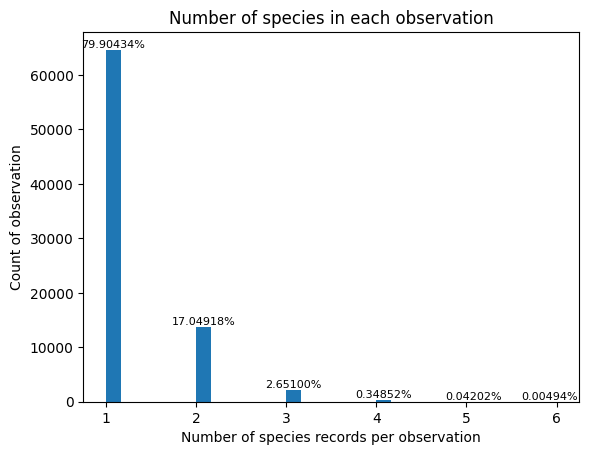

In [5]:
#3. Observe the distribution of how many distinct species are recorded within each checklist.
obs_per_checklist = df.groupby("sub_id").size()
print("\nNumber of species in each observation (summary):")
print(obs_per_checklist.describe())

# Plot
import numpy as np
import matplotlib.pyplot as plt
data = obs_per_checklist.values
total = len(data)
counts, bins, patches = plt.hist(data, bins=30)
plt.xlabel("Number of species records per observation")
plt.ylabel("Count of observation")
plt.title("Number of species in each observation")

for c, p in zip(counts, patches):
    if c > 0:
        percent = c / total * 100
        plt.text(
            p.get_x() + p.get_width() / 2,
            p.get_height(),
            f"{percent:.5f}%",
            ha="center",
            va="bottom",
            fontsize=8
        )
plt.show()

The distribution of the number of species observed in each checklist is shown in the figure above. On average, the number observations per checklist was 80,913.

Number of observations per site (summary):
count    15287.000000
mean         5.292929
std          3.525224
min          1.000000
25%          2.000000
50%          5.000000
75%          8.000000
max         39.000000
Name: sub_id, dtype: float64


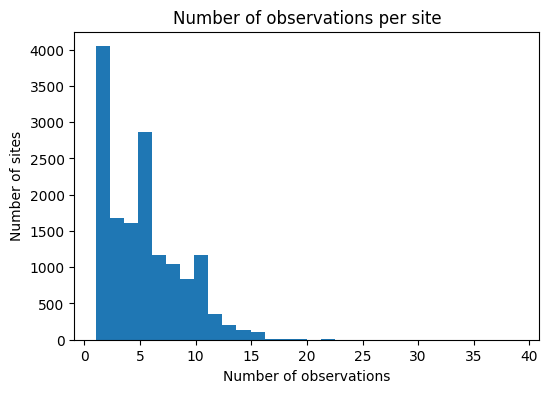

In [6]:
#4. How many checklists correspond to each location?
checklists_per_site = df.groupby("loc_id")["sub_id"].nunique()
print("Number of observations per site (summary):")
print(checklists_per_site.describe())

#Plot
plt.figure(figsize=(6,4))
plt.hist(checklists_per_site, bins=30)

plt.xlabel("Number of observations")
plt.ylabel("Number of sites")
plt.title("Number of observations per site")

plt.show()


The distribution of the number of checklists provided by each site is shown in the figure above. On average, each site provides 5.29 checklists.

In [7]:
#5. Check some locations contribute a large number of checklists (at the top of the list)
print("\nTop 10 sites by number of checklists:")
print(checklists_per_site.sort_values(ascending=False).head(10))


Top 10 sites by number of checklists:
loc_id
L3149107     39
L8142493     36
L3165662     34
L3275296     33
L5181157     32
L12707422    31
L12753440    30
L12797130    26
L13273022    23
L874984      23
Name: sub_id, dtype: int64


These sites rank among the top ten in the submission checklist, suggesting that they may host active bird populations or be frequented by researchers.

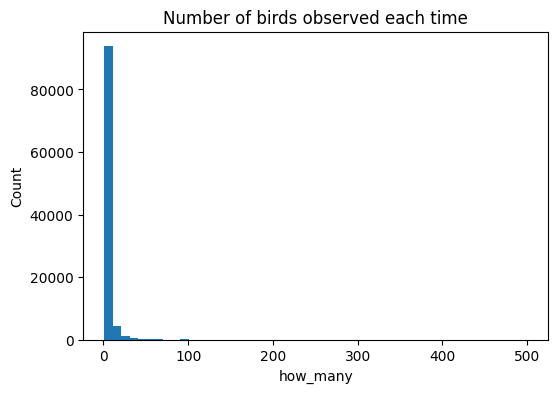

In [8]:
# Number of birds observed each time.
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(df["how_many"], bins=50)
plt.xlabel("how_many")
plt.ylabel("Count")
plt.title("Number of birds observed each time")
plt.show()


##(3)Data quality check and preprocessing

In [9]:
# 1. Missing value rate check
missing_rate = df.isna().mean().sort_values(ascending=False)
print("Missing rate:")
print(missing_rate)

Missing rate:
snow_dep_atleast      0.08876
entry_technique       0.03433
effort_hrs_atleast    0.00161
longitude             0.00000
latitude              0.00000
loc_id                0.00000
sub_id                0.00000
subnational1_code     0.00000
obs_id                0.00000
Month                 0.00000
PROJ_PERIOD_ID        0.00000
species_code          0.00000
Day                   0.00000
Year                  0.00000
valid                 0.00000
how_many              0.00000
reviewed              0.00000
day1_am               0.00000
day2_am               0.00000
day1_pm               0.00000
day2_pm               0.00000
Data_Entry_Method     0.00000
dtype: float64


In [10]:
#2. Missing value fixing
df["snow_dep_atleast"] = df["snow_dep_atleast"].fillna(0)
df["entry_technique"] = df["entry_technique"].fillna("Unknown")
df["effort_hrs_atleast"] = df["effort_hrs_atleast"].fillna(df["effort_hrs_atleast"].median())

It is generally assumed that not writing down an estimated snow depth means there was no snowfall.  
Set the missing observation method category variable to a new value, "unknown".

In [11]:
#3. Double check the missing values
missing_rate = df.isna().mean().sort_values(ascending=False)
print("Missing rate:")
print(missing_rate)

Missing rate:
loc_id                0.0
latitude              0.0
longitude             0.0
subnational1_code     0.0
entry_technique       0.0
sub_id                0.0
obs_id                0.0
Month                 0.0
Day                   0.0
Year                  0.0
PROJ_PERIOD_ID        0.0
species_code          0.0
how_many              0.0
valid                 0.0
reviewed              0.0
day1_am               0.0
day1_pm               0.0
day2_am               0.0
day2_pm               0.0
effort_hrs_atleast    0.0
snow_dep_atleast      0.0
Data_Entry_Method     0.0
dtype: float64


In [12]:
#4. Remove unverified rows (valid = 0)
print("Before:", len(df))
df = df[df["valid"] == 1]
print("After :", len(df))

Before: 100000
After : 99344


In [13]:
#5. Distinguishing variable types

continuous = []
categorical = []
date_like = []

for col in df.columns:
    s = df[col]

    # 1. Explicit date-related fields (by column name)
    if col.lower() in ["year", "month", "day"]:
        date_like.append(col)
        continue

    # 2. Object (string) columns -> categorical
    if s.dtype == "object":
        categorical.append(col)
        continue

    # 3. Numeric columns: decide by number of unique values
    # Small number of unique values usually indicates categorical variables (e.g., 0/1, codes)
    nunique = s.nunique(dropna=True)

    if nunique <= 10:
        categorical.append(col)
    else:
        continuous.append(col)

print("Continuous numeric variables:")
print(continuous)

print("\nCategorical variables:")
print(categorical)

print("\nDate-related fields (to be combined into a timestamp):")
print(date_like)


Continuous numeric variables:
['latitude', 'longitude', 'how_many']

Categorical variables:
['loc_id', 'subnational1_code', 'entry_technique', 'sub_id', 'obs_id', 'PROJ_PERIOD_ID', 'species_code', 'valid', 'reviewed', 'day1_am', 'day1_pm', 'day2_am', 'day2_pm', 'effort_hrs_atleast', 'snow_dep_atleast', 'Data_Entry_Method']

Date-related fields (to be combined into a timestamp):
['Month', 'Day', 'Year']


In [14]:
#6. Transform time info into timestamp
time_cols = ["Year","Month","Day"]
if all(c in df.columns for c in time_cols):
    df["timestamp"] = pd.to_datetime(df[time_cols], errors="coerce")
    df = df.drop(columns=time_cols)
else:
    print("Year / Month / Day have transformed to timestamp")


In [15]:
#7. Outlier detection for continuous numeric variables
df[["latitude","longitude","how_many"]].quantile([0.001, 0.01, 0.99, 0.999]).T

0.001       0.010      0.990      0.999
latitude    26.245115   29.495020  52.024806  61.119073
longitude -149.681829 -123.485384 -68.417653 -62.426870
how_many     1.000000    1.000000  29.000000  65.000000

latitude: 4904 outliers
longitude: 9897 outliers
how_many: 8311 outliers


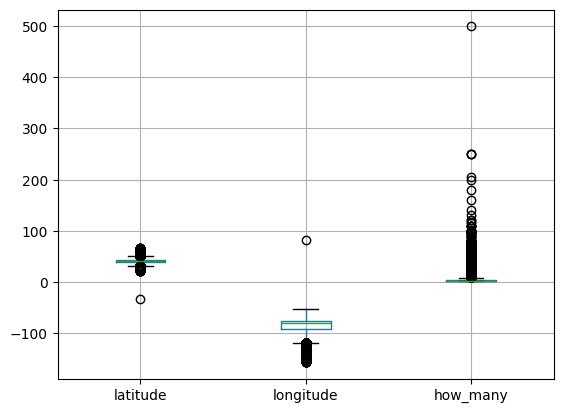

In [16]:
cols = ["latitude", "longitude", "how_many"]

for col in cols:
    s = df[col].dropna()

    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    n_out = ((s < lower) | (s > upper)).sum()
    print(f"{col}: {n_out} outliers")
df[["latitude","longitude","how_many"]].boxplot()
plt.show()

Most continuous numerical values ​​are acceptable.

In [17]:
# Check for extreme values
cols = ["latitude", "longitude", "how_many"]

extreme_points = []

for col in cols:
    s = df[col]

    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    out = df[(s < lower) | (s > upper)].copy()

    if out.empty:
        continue

    out["extreme_distance"] = out[col].apply(
        lambda x: max(lower - x, x - upper)
    )

    extreme_points.append(
        out.sort_values("extreme_distance", ascending=False).head(1)
    )

extreme_df = pd.concat(extreme_points)

extreme_df[["loc_id", "latitude", "longitude", "how_many"]]


loc_id   latitude   longitude  how_many
4853   L10143380 -33.137551   81.826172         1
4853   L10143380 -33.137551   81.826172         1
23976   L4091750  42.696995 -108.705400       500

Delete the observation data from the islands on the west coast of the South Pacific

In [18]:
before = len(df)
df = df[df["loc_id"] != "L10143380"]
after = len(df)
print("Removed rows:", before - after)

Removed rows: 1


In [19]:
out_path = "PFW_OBS_clean.csv"
df.to_csv(out_path, index=False, encoding="utf-8")

##(4)Spatial distribution trends of different bird species

In [20]:
# Check area
df[["latitude", "longitude"]].agg(["min", "max"])

latitude   longitude
min  21.422854 -157.949318
max  65.519890  -52.733096

In [21]:
# Select one of the speices_code in next block
df["species_code"].unique()

array(['amegfi', 'moudov', 'tuftit', 'houspa', 'balori', 'norcar',
       'pinsis', 'whtspa', 'pingro', 'rewbla', 'dowwoo', 'orejun',
       'yerwar', 'eursta', 'annhum', 'whcspa', 'whbnut', 'coshum',
       'reshaw', 'haiwoo', 'orcwar', 'bkcchi', 'easblu', 'amerob',
       'y00033', 'pilwoo', 'varthr', 'rebnut', 'chispa', 'daejun',
       'rebwoo', 'stejay', 'blujay', 'bnhcow', 'carwre', 'herthr',
       'rethaw', 'chbchi', 'houfin', 'calqua', 'carchi', 'monpar',
       'foxspa', 'eucdov', 'mouchi', 'pinwar', 'amecro', 'amtspa',
       'normoc', 'rocpig1', 'norfli', 'lesgol', 'grycat', 'spotow',
       'gilwoo', 'gryjay', 'caltow', 'paibun', 'sonspa', 'yebsap',
       'coohaw', 'btywar', 'comrav', 'wlswar', 'cowscj1', 'brnthr',
       'borchi2', 'brncre', 'pygnut', 'juntit1', 'bewwre', 'purfin',
       'eastow', 'comgra', 'bkbmag1', 'rufhum', 'comred', 'hoared',
       'clanut', 'wiltur', 'yetwar', 'larspa', 'whwdov', 'acowoo',
       'robgro', 'fiscro', 'blkpho', 'wooscj2', 'phaino',

In [22]:
!pip -q install plotly

import json
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from urllib.request import urlopen

# Settings
# Choose ONE species to search
SPECIES = "acowoo"   # <- change to your target species_code

# 0 Load observation data
df = pd.read_csv("/content/PFW_OBS_clean.csv")
df = df[df["valid"] == 1].copy()

# subnational1_code like "US-CA", "CA-ON", sometimes "XX"
df = df[df["subnational1_code"].notna()]
df = df[df["subnational1_code"].str.contains("-", na=False)]
df = df[~df["subnational1_code"].str.startswith("XX", na=False)]


# 1 Load North America admin-1 boundaries (US states + Canada provinces/territories) via Natural Earth GeoJSON
#    (Worldwide file; we'll filter to US/CA)
geojson_url = "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_50m_admin_1_states_provinces.geojson"
with urlopen(geojson_url) as f:
    gj = json.load(f)

# Keep only US/CA features that have iso_3166_2 (e.g., "US-CA", "CA-ON")
features = []
for feat in gj["features"]:
    props = feat.get("properties", {})
    iso2 = props.get("iso_3166_2")
    if iso2 and (iso2.startswith("US-") or iso2.startswith("CA-")):
        features.append(feat)

na_geojson = {"type":"FeatureCollection", "features":features}


# 2 Assign each state/province to the 6 regions (edit if you want different grouping)
region_map = {
    # --- US ---
    "US-AK":"Far North",

    "US-WA":"Northwest","US-OR":"Northwest","US-ID":"Northwest","US-MT":"Northwest",

    "US-CA":"Southwest","US-NV":"Southwest","US-AZ":"Southwest","US-NM":"Southwest","US-UT":"Southwest","US-CO":"Southwest",

    "US-ND":"Central","US-SD":"Central","US-NE":"Central","US-KS":"Central",
    "US-MN":"Central","US-IA":"Central","US-MO":"Central","US-WI":"Central",
    "US-IL":"Central","US-MI":"Central","US-IN":"Central","US-OH":"Central",

    "US-ME":"Northeast","US-NH":"Northeast","US-VT":"Northeast","US-MA":"Northeast","US-RI":"Northeast","US-CT":"Northeast",
    "US-NY":"Northeast","US-NJ":"Northeast","US-PA":"Northeast",

    "US-DE":"Southeast","US-MD":"Southeast","US-DC":"Southeast","US-VA":"Southeast","US-WV":"Southeast","US-NC":"Southeast","US-SC":"Southeast",
    "US-GA":"Southeast","US-FL":"Southeast","US-KY":"Southeast","US-TN":"Southeast","US-AL":"Southeast","US-MS":"Southeast",
    "US-AR":"Southeast","US-LA":"Southeast","US-OK":"Southeast","US-TX":"Southeast",

    # --- Canada (rough grouping to match the example-style regions) ---
    "CA-YT":"Far North","CA-NT":"Far North","CA-NU":"Far North",

    "CA-BC":"Northwest",

    "CA-AB":"Central","CA-SK":"Central","CA-MB":"Central",

    "CA-ON":"Northeast","CA-QC":"Northeast","CA-NB":"Northeast","CA-NS":"Northeast","CA-PE":"Northeast","CA-NL":"Northeast"
}
df["region"] = df["subnational1_code"].map(region_map).fillna("Central")

region_order = ["Far North","Northwest","Southwest","Central","Northeast","Southeast"]
region_to_z = {r:i for i,r in enumerate(region_order)}
region_colors = ["#7D5BA6", "#16B6C6", "#E78AC3", "#33A02C", "#F28E2B", "#D62728"]  # 6 discrete colors

# Region bubble anchor points (rough centers; include Canada)
region_centers = {
    "Far North":  (64.0, -110.0),
    "Northwest":  (53.0, -125.0),
    "Southwest":  (34.0, -112.0),
    "Central":    (49.0,  -97.0),
    "Northeast":  (46.0,  -71.0),
    "Southeast":  (32.5,  -84.0),
}


# 3 Metrics (ALL time; spatial only)
#    Left: % feeders visited = (# unique sites where species appears) / (# unique sites) by region
#    Right: avg flock size when present (mean how_many), aggregated by region (site-level then region-level)

# total unique sites by region
sites_all = df.groupby("region")["loc_id"].nunique().rename("n_sites_all")

# species-present subset
df_sp = df[df["species_code"] == SPECIES].copy()
sites_sp = df_sp.groupby("region")["loc_id"].nunique().rename("n_sites_sp")

metrics = pd.concat([sites_all, sites_sp], axis=1).fillna(0)
metrics["pct_feeders_visited"] = np.where(metrics["n_sites_all"] > 0,
                                         metrics["n_sites_sp"] / metrics["n_sites_all"] * 100, 0)

# avg flock size: mean within site -> mean across sites
loc_mean = df_sp.groupby(["region","loc_id"])["how_many"].mean().rename("loc_mean_how_many").reset_index()
avg_flock = loc_mean.groupby("region")["loc_mean_how_many"].mean().rename("avg_flock_size")

metrics = metrics.join(avg_flock).fillna({"avg_flock_size":0}).reset_index()
metrics["lat"] = metrics["region"].map(lambda r: region_centers[r][0])
metrics["lon"] = metrics["region"].map(lambda r: region_centers[r][1])


# 4 Admin-1 polygons colored by region (US states + Canada provinces/territories)
# Build a table of all admin-1 units we can map
admin_units = []
for feat in na_geojson["features"]:
    iso2 = feat["properties"]["iso_3166_2"]  # "US-CA" / "CA-ON"
    admin_units.append(iso2)
admin_units = pd.Series(admin_units, name="subnational1_code").to_frame()

admin_units["region"] = admin_units["subnational1_code"].map(region_map).fillna("Central")
admin_units["z"] = admin_units["region"].map(region_to_z)


# 5 Plot
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type":"choropleth"}, {"type":"choropleth"}]],
    subplot_titles=("Percent Feeders Visited", "Average Flock Size")
)

for col_i, metric_col, label_fmt, size_expr in [
    (1, "pct_feeders_visited", lambda x: f"{x:.1f}%", lambda x: np.clip(x, 10, 60)),
    (2, "avg_flock_size",      lambda x: f"{x:.3g}",  lambda x: np.clip(x*8, 10, 60)),
]:
    fig.add_trace(
        go.Choropleth(
            geojson=na_geojson,
            featureidkey="properties.iso_3166_2",
            locations=admin_units["subnational1_code"],
            z=admin_units["z"],
            zmin=0, zmax=5,
            colorscale=region_colors,
            showscale=False,
            marker_line_width=0.6
        ),
        row=1, col=col_i
    )

    fig.add_trace(
        go.Scattergeo(
            lon=metrics["lon"], lat=metrics["lat"],
            mode="markers+text",
            text=metrics[metric_col].map(label_fmt),
            textposition="middle center",
            marker=dict(size=size_expr(metrics[metric_col]), opacity=0.35),
            showlegend=False
        ),
        row=1, col=col_i
    )

fig.update_geos(
    scope="north america",
    projection_type="albers",

)



fig.update_layout(
    title=f"{SPECIES} — US + Canada （2020-11-13 to 2021-04-30）",
    height=620, width=1250,
    margin=dict(l=10, r=10, t=70, b=10)
)

fig.show()



##(5)Time distribution trends of different bird species

In [23]:
# Check timeline
time_cols = ["Year","Month","Day"]
if all(c in df.columns for c in time_cols):
    df["timestamp"] = pd.to_datetime(df[time_cols], errors="coerce")
    df = df.drop(columns=time_cols)
else:
    print("Year / Month / Day have transformed to timestamp")

print("Min timestamp:", df["timestamp"].min())
print("Max timestamp:", df["timestamp"].max())

Year / Month / Day have transformed to timestamp
Min timestamp: 2020-11-13
Max timestamp: 2021-04-30


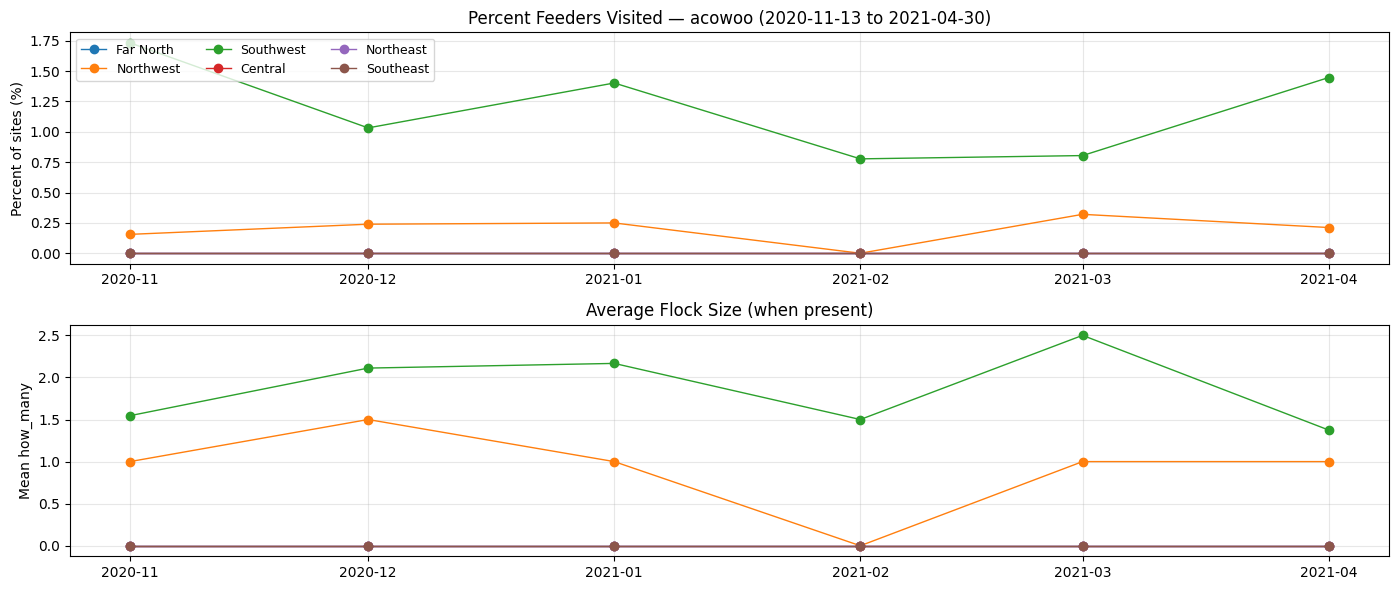

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Settings

SPECIES = "acowoo"   # change to your species_code
FREQ = "M"       # "M"=monthly, "W"=weekly, "D"=daily


# Load and clean

df = pd.read_csv("/content/PFW_2021_public.csv")
df = df[df["valid"] == 1].copy()

df["date"] = pd.to_datetime(df[["Year", "Month", "Day"]], errors="coerce")
df = df.dropna(subset=["date"])

df = df[df["subnational1_code"].notna()]
df = df[df["subnational1_code"].str.contains("-", na=False)]
df = df[df["subnational1_code"] != "XX-"].copy()


# Region mapping (US + Canada)

region_map = {
    # US
    "US-AK": "Far North",
    "US-WA": "Northwest", "US-OR": "Northwest", "US-ID": "Northwest", "US-MT": "Northwest",
    "US-CA": "Southwest", "US-NV": "Southwest", "US-AZ": "Southwest", "US-NM": "Southwest", "US-UT": "Southwest", "US-CO": "Southwest",
    "US-ND": "Central", "US-SD": "Central", "US-NE": "Central", "US-KS": "Central",
    "US-MN": "Central", "US-IA": "Central", "US-MO": "Central", "US-WI": "Central",
    "US-IL": "Central", "US-MI": "Central", "US-IN": "Central", "US-OH": "Central",
    "US-ME": "Northeast", "US-NH": "Northeast", "US-VT": "Northeast", "US-MA": "Northeast",
    "US-RI": "Northeast", "US-CT": "Northeast", "US-NY": "Northeast", "US-NJ": "Northeast", "US-PA": "Northeast",
    "US-DE": "Southeast", "US-MD": "Southeast", "US-DC": "Southeast", "US-VA": "Southeast", "US-WV": "Southeast",
    "US-NC": "Southeast", "US-SC": "Southeast", "US-GA": "Southeast", "US-FL": "Southeast",
    "US-KY": "Southeast", "US-TN": "Southeast", "US-AL": "Southeast", "US-MS": "Southeast",
    "US-AR": "Southeast", "US-LA": "Southeast", "US-OK": "Southeast", "US-TX": "Southeast",

    # Canada
    "CA-YT": "Far North", "CA-NT": "Far North", "CA-NU": "Far North",
    "CA-BC": "Northwest",
    "CA-AB": "Central", "CA-SK": "Central", "CA-MB": "Central",
    "CA-ON": "Northeast", "CA-QC": "Northeast", "CA-NB": "Northeast",
    "CA-NS": "Northeast", "CA-PE": "Northeast", "CA-NL": "Northeast",
}

region_order = ["Far North", "Northwest", "Southwest", "Central", "Northeast", "Southeast"]
df["region"] = df["subnational1_code"].map(region_map).fillna("Central")


# Time bucketing

if FREQ == "M":
    df["t"] = df["date"].dt.to_period("M").dt.to_timestamp()
elif FREQ == "W":
    df["t"] = df["date"].dt.to_period("W").apply(lambda p: p.start_time)
else:
    df["t"] = df["date"].dt.floor("D")


# Metric 1: Percent feeders visited (site coverage)
#   numerator: unique sites where species appears (by time & region)
#   denominator: unique sites observed (by time & region)

sites_all = df.groupby(["t", "region"])["loc_id"].nunique().rename("n_sites_all")

df_sp = df[df["species_code"] == SPECIES].copy()
sites_sp = df_sp.groupby(["t", "region"])["loc_id"].nunique().rename("n_sites_sp")

m = pd.concat([sites_all, sites_sp], axis=1).fillna(0)
m["pct_feeders_visited"] = np.where(
    m["n_sites_all"] > 0,
    (m["n_sites_sp"] / m["n_sites_all"]) * 100,
    0
)


# Metric 2: Average flock size when present
#   compute mean how_many within site first, then average across sites
loc_mean = (
    df_sp.groupby(["t", "region", "loc_id"])["how_many"]
    .mean()
    .rename("loc_mean_how_many")
    .reset_index()
)

avg_flock = (
    loc_mean.groupby(["t", "region"])["loc_mean_how_many"]
    .mean()
    .rename("avg_flock_size")
)

m = m.join(avg_flock).fillna({"avg_flock_size": 0}).reset_index()

p1 = m.pivot(index="t", columns="region", values="pct_feeders_visited").reindex(columns=region_order)
p2 = m.pivot(index="t", columns="region", values="avg_flock_size").reindex(columns=region_order)


# Plot
start_date = df["date"].min().date()
end_date = df["date"].max().date()

plt.figure(figsize=(14, 6))

ax1 = plt.subplot(2, 1, 1)
for r in region_order:
    ax1.plot(p1.index, p1[r], marker="o", linewidth=1)
ax1.set_title(f"Percent Feeders Visited — {SPECIES} ({start_date} to {end_date})")
ax1.set_ylabel("Percent of sites (%)")
ax1.grid(True, alpha=0.3)
ax1.legend(region_order, ncol=3, fontsize=9, loc="upper left")

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
for r in region_order:
    ax2.plot(p2.index, p2[r], marker="o", linewidth=1)
ax2.set_title("Average Flock Size (when present)")
ax2.set_ylabel("Mean how_many")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


##(6)Frequency distribution of different bird species in different months



In [25]:
import pandas as pd

# Load and basic cleaning

df = pd.read_csv("/content/PFW_2021_public.csv")

df = df[df["valid"] == 1].copy()

df = df[df["subnational1_code"].notna()]
df = df[df["subnational1_code"].str.contains("-", na=False)]
df = df[df["subnational1_code"] != "XX"]


# Build date and month
df["date"] = pd.to_datetime(df[["Year","Month","Day"]], errors="coerce")
df = df.dropna(subset=["date"])
df["month"] = df["date"].dt.to_period("M").astype(str)


# Region mapping
region_map = {
    "US-AK":"Far North",

    "US-WA":"Northwest","US-OR":"Northwest","US-ID":"Northwest","US-MT":"Northwest",

    "US-CA":"Southwest","US-NV":"Southwest","US-AZ":"Southwest","US-NM":"Southwest","US-UT":"Southwest","US-CO":"Southwest",

    "US-ND":"Central","US-SD":"Central","US-NE":"Central","US-KS":"Central",
    "US-MN":"Central","US-IA":"Central","US-MO":"Central","US-WI":"Central",
    "US-IL":"Central","US-MI":"Central","US-IN":"Central","US-OH":"Central",

    "US-ME":"Northeast","US-NH":"Northeast","US-VT":"Northeast","US-MA":"Northeast",
    "US-RI":"Northeast","US-CT":"Northeast","US-NY":"Northeast","US-NJ":"Northeast","US-PA":"Northeast",

    "US-DE":"Southeast","US-MD":"Southeast","US-DC":"Southeast","US-VA":"Southeast","US-WV":"Southeast",
    "US-NC":"Southeast","US-SC":"Southeast","US-GA":"Southeast","US-FL":"Southeast",
    "US-KY":"Southeast","US-TN":"Southeast","US-AL":"Southeast","US-MS":"Southeast",
    "US-AR":"Southeast","US-LA":"Southeast","US-OK":"Southeast","US-TX":"Southeast",

    "CA-YT":"Far North","CA-NT":"Far North","CA-NU":"Far North",
    "CA-BC":"Northwest",
    "CA-AB":"Central","CA-SK":"Central","CA-MB":"Central",
    "CA-ON":"Northeast","CA-QC":"Northeast","CA-NB":"Northeast",
    "CA-NS":"Northeast","CA-PE":"Northeast","CA-NL":"Northeast"
}

df["region"] = df["subnational1_code"].map(region_map).fillna("Central")


# Count species frequency
# per month × region
#
counts = (
    df
    .groupby(["month", "region", "species_code"])
    .size()
    .reset_index(name="n_records")
)

# Top 5 species per month × region

top5 = (
    counts
    .sort_values(["month", "region", "n_records"], ascending=[True, True, False])
    .groupby(["month", "region"])
    .head(5)
    .reset_index(drop=True)
)

from IPython.display import display
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 200)

display(top5)


month     region species_code  n_records
0    2020-11    Central       norcar        174
1    2020-11    Central       blujay        167
2    2020-11    Central       dowwoo        167
3    2020-11    Central       bkcchi        160
4    2020-11    Central       whbnut        151
5    2020-11  Far North       dowwoo          5
6    2020-11  Far North       pingro          4
7    2020-11  Far North      bkbmag1          3
8    2020-11  Far North       rebnut          3
9    2020-11  Far North       bkcchi          2
10   2020-11  Northeast       bkcchi        344
11   2020-11  Northeast       blujay        331
12   2020-11  Northeast       whbnut        320
13   2020-11  Northeast       daejun        290
14   2020-11  Northeast       norcar        287
15   2020-11  Northwest       bkcchi         77
16   2020-11  Northwest       norfli         69
17   2020-11  Northwest       daejun         66
18   2020-11  Northwest       houfin         52
19   2020-11  Northwest       rebnut         52
20   2020-11  Southeast       norcar        190
21   2020-11  Southeast       carwre        143
22   2020-11  Southeast       tuftit        143
23   2020-11  Southeast       moudov        142
24   2020-11  Southeast       carchi        140
25   2020-11  Southwest       daejun         76
26   2020-11  Southwest       houfin         75
27   2020-11  Southwest       whcspa         45
28   2020-11  Southwest       lesgol         42
29   2020-11  Southwest       annhum         38
30   2020-12    Central       dowwoo        260
31   2020-12    Central       daejun        257
32   2020-12    Central       bkcchi        254
33   2020-12    Central       norcar        242
34   2020-12    Central       blujay        236
35   2020-12  Far North       rebnut          7
36   2020-12  Far North       pingro          6
37   2020-12  Far North       bkcchi          5
38   2020-12  Far North      borchi2          4
39   2020-12  Far North      bkbmag1          3
40   2020-12  Northeast       bkcchi        572
41   2020-12  Northeast       blujay        481
42   2020-12  Northeast       dowwoo        480
43   2020-12  Northeast       moudov        465
44   2020-12  Northeast       daejun        452
45   2020-12  Northwest       daejun        109
46   2020-12  Northwest       bkcchi        108
47   2020-12  Northwest       houfin         85
48   2020-12  Northwest       annhum         84
49   2020-12  Northwest       pinsis         76
50   2020-12  Southeast       norcar        296
51   2020-12  Southeast       tuftit        258
52   2020-12  Southeast       moudov        242
53   2020-12  Southeast       dowwoo        232
54   2020-12  Southeast       houfin        224
55   2020-12  Southwest       houfin        126
56   2020-12  Southwest       daejun        108
57   2020-12  Southwest       whcspa         69
58   2020-12  Southwest       lesgol         58
59   2020-12  Southwest       pinsis         57
60   2021-01    Central       dowwoo        312
61   2021-01    Central       daejun        269
62   2021-01    Central       norcar        267
63   2021-01    Central       houspa        256
64   2021-01    Central       bkcchi        248
65   2021-01  Far North       rebnut          9
66   2021-01  Far North       comred          6
67   2021-01  Far North       bkcchi          4
68   2021-01  Far North       dowwoo          4
69   2021-01  Far North      borchi2          2
70   2021-01  Northeast       bkcchi        569
71   2021-01  Northeast       whbnut        559
72   2021-01  Northeast       dowwoo        534
73   2021-01  Northeast       daejun        511
74   2021-01  Northeast       blujay        484
75   2021-01  Northwest       bkcchi        113
76   2021-01  Northwest       daejun        112
77   2021-01  Northwest       rebnut         98
78   2021-01  Northwest       annhum         87
79   2021-01  Northwest       spotow         80
80   2021-01  Southeast       norcar        339
81   2021-01  Southeast       tuftit        288
82   2021-01  Southeast

##(7)The impact of effort bias on the results

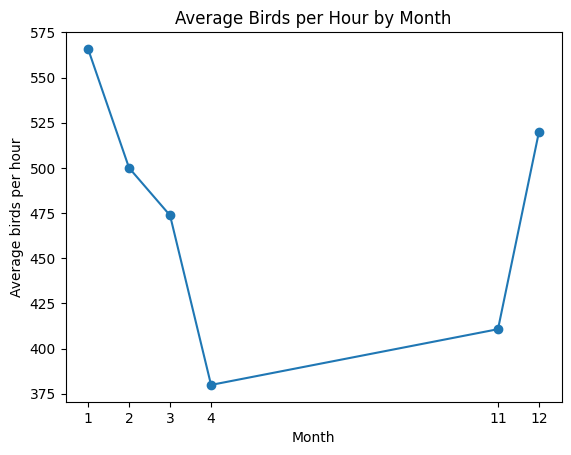

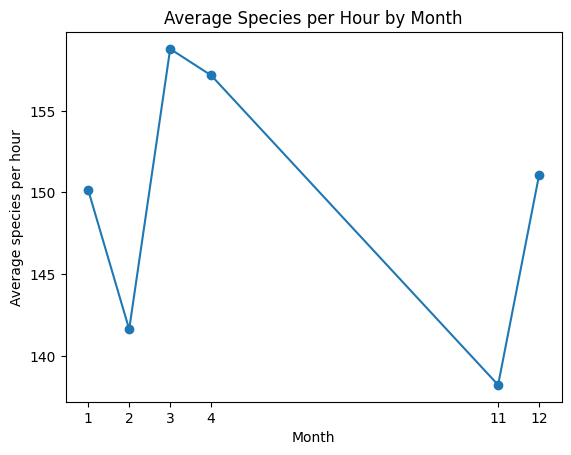

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load data
df = pd.read_csv("/content/PFW_2021_public.csv")

# 2) Keep valid observations + avoid division by 0
df = df[(df["valid"] == 1) & (df["effort_hrs_atleast"] > 0)]

# 3) Aggregate to checklist level (sub_id)
# Each sub_id = one checklist (one survey session)
checklist = (
    df.groupby("sub_id")
      .agg(
          total_birds=("how_many", "sum"),          # total birds seen in the checklist
          n_species=("species_code", "nunique"),    # number of unique species in the checklist
          effort_hours=("effort_hrs_atleast", "first"),
          Month=("Month", "first")
      )
      .reset_index()
)

# 4) Standardize by effort (control effort bias)
checklist["birds_per_hour"] = checklist["total_birds"] / checklist["effort_hours"]
checklist["species_per_hour"] = checklist["n_species"] / checklist["effort_hours"]

# 5) Monthly mean trends
monthly = (
    checklist.groupby("Month")[["birds_per_hour", "species_per_hour"]]
             .mean()
             .reset_index()
             .sort_values("Month")
)

# 6) Plot 1: Average birds per hour by month
plt.figure()
plt.plot(monthly["Month"], monthly["birds_per_hour"], marker="o")
plt.xlabel("Month")
plt.ylabel("Average birds per hour")
plt.title("Average Birds per Hour by Month")
plt.xticks(sorted(monthly["Month"].unique()))
plt.show()

# 7) Plot 2: Average species per hour by month
plt.figure()
plt.plot(monthly["Month"], monthly["species_per_hour"], marker="o")
plt.xlabel("Month")
plt.ylabel("Average species per hour")
plt.title("Average Species per Hour by Month")
plt.xticks(sorted(monthly["Month"].unique()))
plt.show()


To control for observation effort, we normalize both bird counts and species richness by survey duration and analyze birds per hour and species per hour instead of raw counts.

##(8)Species richness vs. diversity (Shannon index)

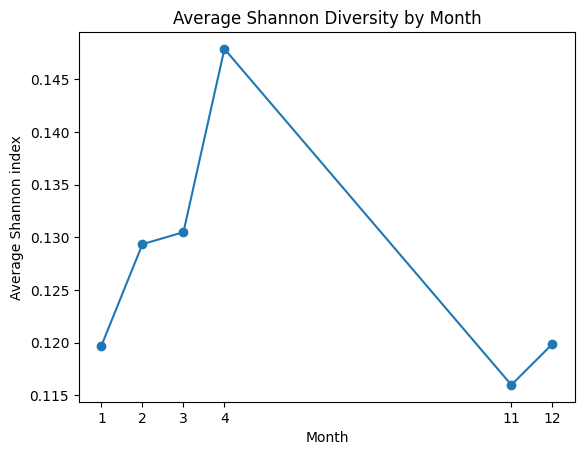

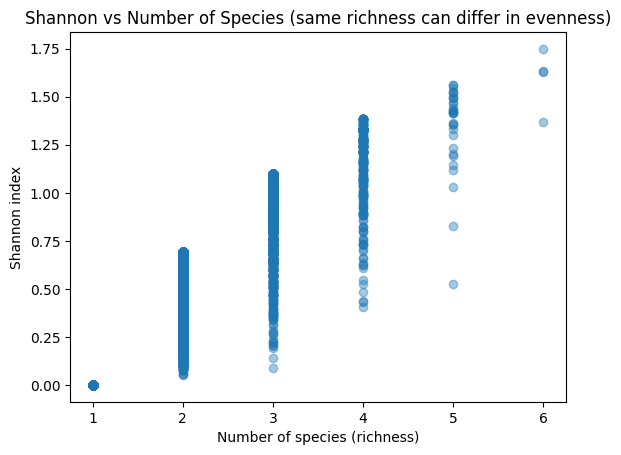

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 1) Load & basic cleaning
df = pd.read_csv("/content/PFW_2021_public.csv")

# Keep valid + remove zero/negative effort if you later want "per hour" metrics
df = df[(df["valid"] == 1)].copy()

# how_many might have missing; treat missing as 0 (or drop)
df["how_many"] = pd.to_numeric(df["how_many"], errors="coerce").fillna(0)

# 2) Build species counts per checklist
#    Each row: (sub_id, species_code) total individuals in that checklist

sp_counts = (
    df.groupby(["sub_id", "species_code", "Month"], as_index=False)
      .agg(species_count=("how_many", "sum"),
           effort_hours=("effort_hrs_atleast", "first"))
)

# total individuals per checklist
totals = (
    sp_counts.groupby("sub_id", as_index=False)
             .agg(total_birds=("species_count", "sum"))
)

sp_counts = sp_counts.merge(totals, on="sub_id", how="left")

# avoid divide-by-zero: drop checklists with 0 total birds
sp_counts = sp_counts[sp_counts["total_birds"] > 0].copy()

# p_i = species proportion within checklist
sp_counts["p_i"] = sp_counts["species_count"] / sp_counts["total_birds"]


# 3) Shannon & Simpson per checklist
#    Shannon: -Σ p_i * ln(p_i)
#    Simpson (Gini-Simpson): 1 - Σ p_i^2

diversity = (
    sp_counts.groupby("sub_id", as_index=False)
             .agg(
                 Month=("Month", "first"),
                 effort_hours=("effort_hours", "first"),
                 n_species=("species_code", "nunique"),
                 shannon=("p_i", lambda x: -np.sum(x * np.log(x))),
                 simpson=("p_i", lambda x: 1 - np.sum(x**2)),
                 total_birds=("total_birds", "first")
             )
)

# (Optional) If you also want effort-standardized richness
diversity = diversity[(diversity["effort_hours"] > 0)].copy()
diversity["species_per_hour"] = diversity["n_species"] / diversity["effort_hours"]
diversity["birds_per_hour"] = diversity["total_birds"] / diversity["effort_hours"]

# 4) Visualization A: Monthly mean trends
monthly = (
    diversity.groupby("Month")[["shannon", "simpson", "n_species"]]
             .mean()
             .reset_index()
             .sort_values("Month")
)

plt.figure()
plt.plot(monthly["Month"], monthly["shannon"], marker="o")
plt.xlabel("Month")
plt.ylabel("Average Shannon index")
plt.title("Average Shannon Diversity by Month")
plt.xticks(sorted(monthly["Month"].unique()))
plt.show()



# 5) Visualization B: Why it matters
#    Same n_species can have different Shannon

plt.figure()
plt.scatter(diversity["n_species"], diversity["shannon"], alpha=0.4)
plt.xlabel("Number of species (richness)")
plt.ylabel("Shannon index")
plt.title("Shannon vs Number of Species (same richness can differ in evenness)")
plt.show()


For the same species richness, the Shannon index varies substantially, indicating that community evenness differs across checklists.

##(9) Co-ocurrance matrix

Perform a species co-occurrence analysis on the df_pfw DataFrame. This involves transforming the data into a checklist-species presence matrix, calculating a species co-occurrence matrix, constructing a network graph where species are nodes and co-occurrence frequency determines edge weights (with a defined threshold), and visualizing this network. Finally, summarize the key insights about species relationships and communities observed from the network.

First 5 rows and columns of the presence matrix:


species_code  abetow  accipi  acowoo  allhum  altori  ambduc  amecoo  amecro  amegfi  amekes  amekes1  amered  amerob  amtspa  anhing  annhum  astfly  audori  audwar  baleag  balori  barswa  \
sub_id                                                                                                                                                                                          
S76222515          0       0       0       0       0       0       0       0       0       0        0       0       0       0       0       0       0       0       0       0       0       0   
S76222722          0       0       0       0       0       0       0       0       0       0        0       0       0       0       0       0       0       0       0       0       0       0   
S76222829          0       0       0       0       0       0       0       0       0       0        0       0       0       0       0       0       0       0       0       0       0       0   
S76222835          0       0       0       0       0       0       0       0       0       0        0       0       1       0       0       0       0       0       0       0       0       0   
S76222849          0       0       0       0       0       0       0       0       0       0        0       0       0       0       0       0       0       0       0       0       0       0   

species_code  batpig1  bawwar  bbwduc  ...  wooduc  wooscj2  woosto  woothr  wrenti  x00004  x00195  x00422  y00033  y00226  y00227  y00322  y00327  y00471  y00475  yebmag  yebsap  yehbla  yelwar  \
sub_id                                 ...                                                                                                                                                            
S76222515           0       0       0  ...       0        0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0   
S76222722           0       0       0  ...       0        0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0   
S76222829           0       0       0  ...       0        0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0   
S76222835           0       0       0  ...       0        0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0   
S76222849           0       0       0  ...       0        0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0   

species_code  yerwar  yerwar3  yesfli  yetvir  yetwar  zebdov  
sub_id                                                         
S76222515          0        0       0       0       0       0  
S76222722          0        0       0       0       0       0  
S76222829          0        0       0       0       0       0  
S76222835          0        0       0       0       0       0  
S76222849          0        0       0       0       0       0  

[5 rows x 361 columns]

First 5 rows and columns of the species co-occurrence matrix:


species_code  abetow  accipi  acowoo  allhum  altori  ambduc  amecoo  amecro  amegfi  amekes  amekes1  amered  amerob  amtspa  anhing  annhum  astfly  audori  audwar  baleag  balori  barswa  \
species_code                                                                                                                                                                                    
abetow            30       0       0       0       0       0       0       0       0       0        0       0       0       0       0       0       0       0       0       0       0       0   
accipi             0       8       0       0       0       0       0       0       0       0        0       0       0       0       0       0       0       0       0       0       0       0   
acowoo             0       0      60       0       0       0       0       0       0       0        0       0       0       0       0       1       0       0       0       0       0       0   
allhum             0       0       0      51       0       0       0       1       1       0        0       0       0       0       0       0       0       0       0       0       0       0   
altori             0       0       0       0       1       0       0       0       0       0        0       0       0       0       0       0       0       0       0       0       0       0   

species_code  batpig1  bawwar  bbwduc  ...  wooduc  wooscj2  woosto  woothr  wrenti  x00004  x00195  x00422  y00033  y00226  y00227  y00322  y00327  y00471  y00475  yebmag  yebsap  yehbla  yelwar  \
species_code                           ...                                                                                                                                                            
abetow              0       0       0  ...       0        0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0   
accipi              0       0       0  ...       0        0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0   
acowoo              0       0       0  ...       0        0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0   
allhum              1       0       0  ...       0        0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0   
altori              0       0       0  ...       0        0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0   

species_code  yerwar  yerwar3  yesfli  yetvir  yetwar  zebdov  
species_code                                                   
abetow             0        0       0       0       0       0  
accipi             0        0       0       0       0       0  
acowoo             0        0       0       0       0       0  
allhum             1        0       0       0       0       0  
altori             0        0       0       0       0       0  

[5 rows x 361 columns]

Constructing and visualizing species co-occurrence network...
Network created with 11 nodes and 32 edges (threshold > 100).


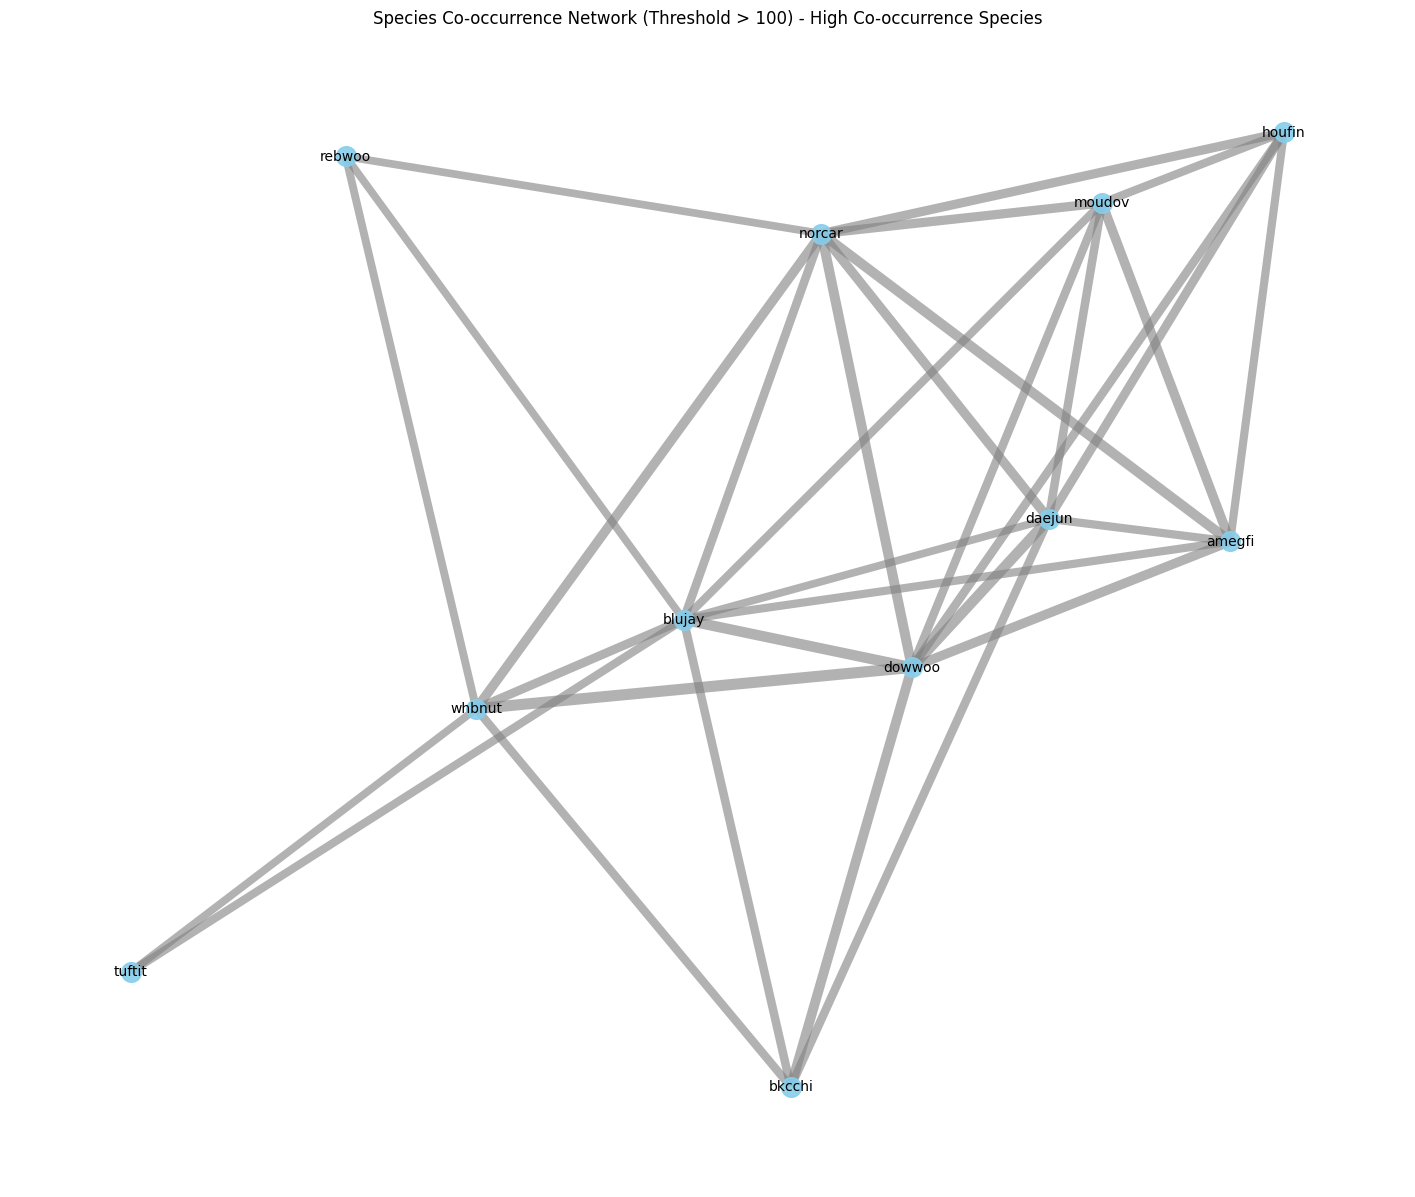

In [28]:
# Create a cross-tabulation of sub_id and species_code
# This gives the count of each species in each checklist

df_pfw=pd.read_csv("/content/PFW_2021_public.csv")

checklist_species_counts = pd.crosstab(df_pfw['sub_id'], df_pfw['species_code'])

# Convert counts to binary (presence/absence)
# Any count > 0 becomes 1 (present), 0 remains 0 (absent)
presence_matrix = (checklist_species_counts > 0).astype(int)

print("First 5 rows and columns of the presence matrix:")
display(presence_matrix.head())


# Calculate the co-occurrence matrix
# Transpose the presence_matrix and multiply it by the original presence_matrix
co_occurrence_matrix = presence_matrix.T.dot(presence_matrix)

print("First 5 rows and columns of the species co-occurrence matrix:")
display(co_occurrence_matrix.head())



import networkx as nx
import matplotlib.pyplot as plt

print("Constructing and visualizing species co-occurrence network...")

# Initialize a graph
G = nx.Graph()

# Define a co-occurrence threshold
# We will only add edges for co-occurrences above this value
# A higher threshold reduces the complexity of the graph
co_occurrence_threshold = 100 # Increased threshold for 'high co-occurrence'

# Add edges based on co-occurrence matrix
# Iterate through the upper triangle of the matrix to avoid duplicate edges and self-loops
for i in range(len(co_occurrence_matrix.columns)):
    for j in range(i + 1, len(co_occurrence_matrix.columns)): # Only upper triangle, exclude diagonal
        species1 = co_occurrence_matrix.columns[i]
        species2 = co_occurrence_matrix.columns[j]
        weight = co_occurrence_matrix.iloc[i, j]

        if weight > co_occurrence_threshold:
            G.add_edge(species1, species2, weight=weight)

# Remove isolated nodes (species not involved in any co-occurrence above the threshold)
# This ensures only species with significant co-occurrence are displayed
G.remove_nodes_from(list(nx.isolates(G)))

print(f"Network created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges (threshold > {co_occurrence_threshold}).")

# Visualize the network
plt.figure(figsize=(18, 15)) # Larger figure size for better spread
pos = nx.spring_layout(G, k=0.3, iterations=50) # Adjust k and iterations for better node spacing

# Draw nodes (only the connected ones remain in G after removing isolates)
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue', alpha=0.9) # Increased node size

# Draw edges, scaling width by weight for better visualization of stronger co-occurrences
edges = G.edges(data=True)
weights = [d['weight'] for u, v, d in edges]
# Avoid division by zero if no edges meet the threshold
if weights:
    max_weight = max(weights)
    edge_widths = [w/max_weight*8 for w in weights] # Increased max width for edges
else:
    edge_widths = []
nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, alpha=0.6, edge_color='gray')

# Draw labels for all remaining (connected) nodes in the filtered graph
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black') # Display labels for all visible nodes

plt.title(f'Species Co-occurrence Network (Threshold > {co_occurrence_threshold}) - High Co-occurrence Species')
plt.axis('off') # Hide axes
plt.show()

In [29]:
print("Extracting and displaying the top co-occurring species pairs...")

# Get the upper triangle of the co-occurrence matrix to avoid duplicate pairs and self-co-occurrence
co_occurrence_pairs = co_occurrence_matrix.stack()
co_occurrence_pairs = co_occurrence_pairs[co_occurrence_pairs.index.get_level_values(0) < co_occurrence_pairs.index.get_level_values(1)]

# Rename the index levels to avoid column name conflict during reset_index
co_occurrence_pairs.index.set_names(['Species1', 'Species2'], inplace=True)

# Convert to DataFrame and rename the values column
co_occurrence_df = co_occurrence_pairs.reset_index(name='Co_occurrence_Count')

# Sort by co-occurrence count in descending order and display the top 10
top_co_occurring_species = co_occurrence_df.sort_values(by='Co_occurrence_Count', ascending=False).head(10)
display(top_co_occurring_species)

Extracting and displaying the top co-occurring species pairs...


Species1 Species2  Co_occurrence_Count
33565   dowwoo   whbnut                  147
32343   daejun   dowwoo                  139
14007   blujay   dowwoo                  139
3046    amegfi   norcar                  132
33447   dowwoo   norcar                  132
10443   bkcchi   dowwoo                  130
52694   norcar   whbnut                  126
3038    amegfi   moudov                  126
32437   daejun   norcar                  125
2952    amegfi   dowwoo                  125

#3.EDA for PFW_count_site_data_public_2021

##(1)Description of the dataset about PFW_count_site_data_public_2021.csv

###Description：The dataset describes the static environmental and facility characteristics of bird observation sites, with a core focus on habitat types and human management practices at survey locations. It details each site's courtyard type, surrounding habitat composition (such as woodland, grassland, and water bodies), vegetation and water availability, feeder types and quantities, alongside factors potentially influencing bird activity (such as the frequency of cats, dogs, and squirrels) and feeding habits. This dataset comprises site-level attribute data, serving to contextualise the environmental and anthropogenic factors underlying bird observation results.

##(2)Data structure check

In [30]:
import pandas as pd
df = pd.read_csv("/content/PFW_count_site_data_public_2021.csv")
print("Rows, Columns:", df.shape)

Rows, Columns: (254355, 62)


In [31]:
df.dtypes

loc_id                           object
proj_period_id                   object
yard_type_pavement              float64
yard_type_garden                float64
yard_type_landsca               float64
yard_type_woods                 float64
yard_type_desert                float64
hab_dcid_woods                  float64
hab_evgr_woods                  float64
hab_mixed_woods                 float64
hab_orchard                     float64
hab_park                        float64
hab_water_fresh                 float64
hab_water_salt                  float64
hab_residential                 float64
hab_industrial                  float64
hab_agricultural                float64
hab_desert_scrub                float64
hab_young_woods                 float64
hab_swamp                       float64
hab_marsh                       float64
evgr_trees_atleast              float64
evgr_shrbs_atleast              float64
dcid_trees_atleast              float64
dcid_shrbs_atleast              float64
fru_trees_atleast               float64
cacti_atleast                   float64
brsh_piles_atleast              float64
water_srcs_atleast              float64
bird_baths_atleast              float64
nearby_feeders                  float64
squirrels                       float64
cats                            float64
dogs                            float64
humans                          float64
housing_density                 float64
fed_yr_round                    float64
fed_in_jan                      float64
fed_in_feb                      float64
fed_in_mar                      float64
fed_in_apr                      float64
fed_in_may                      float64
fed_in_jun                      float64
fed_in_jul                      float64
fed_in_aug                      float64
fed_in_sep                      float64
fed_in_oct                      float64
fed_in_nov                      float64
fed_in_dec                      float64
numfeeders_suet                 float64
numfeeders_ground               float64
numfeeders_hanging              float64
numfeeders_platfrm              float64
numfeeders_humming              float64
numfeeders_water                float64
numfeeders_thistle              float64
numfeeders_fruit                float64
numfeeders_hopper               float64
numfeeders_tube                 float64
numfeeders_other                float64
population_atleast              float64
count_area_size_sq_m_atleast    float64
dtype: object

In [32]:
import pandas as pd

df = pd.read_csv("/content/PFW_count_site_data_public_2021.csv")

# Show unique values (and counts) for each column
for col in df.columns:
    print("=" * 60)
    print(f"Column: {col}")
    print("Number of unique values:", df[col].nunique(dropna=True))

    # Show value counts (including NaN)
    print(df[col].value_counts(dropna=False))


Column: loc_id
Number of unique values: 91105
loc_id
L36031       33
L33888       33
L22111       33
L33282       32
L33190       32
             ..
L34380        1
L34378        1
L34376        1
L3437550      1
L13437971     1
Name: count, Length: 91105, dtype: int64
Column: proj_period_id
Number of unique values: 33
proj_period_id
PFW_2021    13222
PFW_2020    11262
PFW_2015    10516
PFW_2016    10484
PFW_2017    10346
PFW_2019    10320
PFW_2018    10257
PFW_2014    10193
PFW_2003     9496
PFW_2002     9342
PFW_2001     9198
PFW_2004     9173
PFW_2005     9120
PFW_2000     8651
PFW_2013     8357
PFW_1999     7199
PFW_2012     7001
PFW_2011     6930
PFW_2006     6688
PFW_2008     6669
PFW_1998     6605
PFW_2007     6500
PFW_2010     6221
PFW_2009     6164
PFW_1995     5917
PFW_1997     5669
PFW_1996     5470
PFW_1990     5013
PFW_1994     4760
PFW_1993     4543
PFW_1989     4492
PFW_1992     4320
PFW_1991     4257
Name: count, dtype: int64
Column: yard_type_pavement
Number of unique 

##(3)Data quality check and preprocessing

Group the columns

In [33]:
import pandas as pd

df = pd.read_csv("/content/PFW_count_site_data_public_2021.csv")

# Manually categorize each variable

# ① Feeders identifiers
id_cols = ["loc_id", "proj_period_id"]

# ② Yard / site type variables
yard_cols = [c for c in df.columns if c.startswith("yard_type_")]

# ③ Habitat type variables
hab_cols = [c for c in df.columns if c.startswith("hab_")]

# ④ Vegetation and environmental count variables (minimum counts, *_atleast)
environment_cols = [c for c in df.columns if c.endswith("_atleast")] + [
    "nearby_feeders", "housing_density"
]

# ⑤ Disturbance / human and animal activity variables
disturbance_cols = ["squirrels", "cats", "dogs", "humans"]

# ⑥ Feeding behavior over time (year-round and monthly indicators)
feeding_time_cols = ["fed_yr_round"] + [
    c for c in df.columns if c.startswith("fed_in_")
]

# ⑦ Feeder type and quantity variables
feeder_cols = [c for c in df.columns if c.startswith("numfeeders_")]


# Store all variable groups in a dictionary for convenient EDA
feature_groups = {
    "identifiers": id_cols,
    "yard_type": yard_cols,
    "habitat": hab_cols,
    "environment": environment_cols,
    "disturbance": disturbance_cols,
    "feeding_time": feeding_time_cols,
    "num_diff_types_feeder": feeder_cols
}

# Quick check: number of variables in each group
for k, v in feature_groups.items():
    print(k, len(v))


identifiers 2
yard_type 5
habitat 14
environment 13
disturbance 4
feeding_time 13
num_diff_types_feeder 11


In [34]:
print("identifiers", id_cols)
print("yard:", yard_cols)
print("hab:", hab_cols)
print("environment:", environment_cols)
print("disturbance:", disturbance_cols)
print("feeding time:", feeding_time_cols)
print("num_diff_types_feeder:", feeder_cols)



identifiers ['loc_id', 'proj_period_id']
yard: ['yard_type_pavement', 'yard_type_garden', 'yard_type_landsca', 'yard_type_woods', 'yard_type_desert']
hab: ['hab_dcid_woods', 'hab_evgr_woods', 'hab_mixed_woods', 'hab_orchard', 'hab_park', 'hab_water_fresh', 'hab_water_salt', 'hab_residential', 'hab_industrial', 'hab_agricultural', 'hab_desert_scrub', 'hab_young_woods', 'hab_swamp', 'hab_marsh']
environment: ['evgr_trees_atleast', 'evgr_shrbs_atleast', 'dcid_trees_atleast', 'dcid_shrbs_atleast', 'fru_trees_atleast', 'cacti_atleast', 'brsh_piles_atleast', 'water_srcs_atleast', 'bird_baths_atleast', 'population_atleast', 'count_area_size_sq_m_atleast', 'nearby_feeders', 'housing_density']
disturbance: ['squirrels', 'cats', 'dogs', 'humans']
feeding time: ['fed_yr_round', 'fed_in_jan', 'fed_in_feb', 'fed_in_mar', 'fed_in_apr', 'fed_in_may', 'fed_in_jun', 'fed_in_jul', 'fed_in_aug', 'fed_in_sep', 'fed_in_oct', 'fed_in_nov', 'fed_in_dec']
num_diff_types_feeder: ['numfeeders_suet', 'numfeeders

Check missing value rate by group

In [35]:
# Missing value summary by variable group
group_missing_summary = {}

for group_name, cols in feature_groups.items():
    sub_df = df[cols]

    group_missing_summary[group_name] = pd.DataFrame({
        "missing_count": sub_df.isna().sum(),
        "missing_rate": (sub_df.isna().sum() / len(df)).round(4)
    }).sort_values("missing_rate", ascending=False)

# Print missing values for each group
for group_name, miss_df in group_missing_summary.items():
    print("=" * 80)
    print(f"Group: {group_name}")
    display(miss_df)

Group: identifiers


missing_count  missing_rate
loc_id                      0           0.0
proj_period_id              0           0.0

Group: yard_type


missing_count  missing_rate
yard_type_pavement          68877        0.2708
yard_type_desert            68782        0.2704
yard_type_garden            68282        0.2685
yard_type_woods             67628        0.2659
yard_type_landsca           63017        0.2478

Group: habitat


missing_count  missing_rate
hab_park                 116534        0.4582
hab_swamp                115086        0.4525
hab_marsh                 91140        0.3583
hab_young_woods           82494        0.3243
hab_orchard               79599        0.3129
hab_agricultural          78850        0.3100
hab_water_salt            77087        0.3031
hab_desert_scrub          77001        0.3027
hab_evgr_woods            61690        0.2425
hab_industrial            61649        0.2424
hab_dcid_woods            50114        0.1970
hab_water_fresh           47259        0.1858
hab_mixed_woods           42404        0.1667
hab_residential           38110        0.1498

Group: environment


missing_count  missing_rate
water_srcs_atleast                    64915        0.2552
bird_baths_atleast                    58343        0.2294
fru_trees_atleast                     56583        0.2225
cacti_atleast                         56066        0.2204
brsh_piles_atleast                    48434        0.1904
evgr_shrbs_atleast                    33592        0.1321
dcid_shrbs_atleast                    32109        0.1262
nearby_feeders                        29486        0.1159
population_atleast                    29384        0.1155
evgr_trees_atleast                    29181        0.1147
dcid_trees_atleast                    27709        0.1089
count_area_size_sq_m_atleast          26622        0.1047
housing_density                       23893        0.0939

Group: disturbance


missing_count  missing_rate
dogs               37386        0.1470
cats               35503        0.1396
humans             27107        0.1066
squirrels          18670        0.0734

Group: feeding_time


missing_count  missing_rate
fed_yr_round         173165        0.6808
fed_in_jul            64739        0.2545
fed_in_aug            64669        0.2542
fed_in_jun            64002        0.2516
fed_in_sep            62945        0.2475
fed_in_may            62200        0.2445
fed_in_oct            60159        0.2365
fed_in_apr            59035        0.2321
fed_in_mar            57856        0.2275
fed_in_feb            57788        0.2272
fed_in_jan            57691        0.2268
fed_in_dec            57613        0.2265
fed_in_nov            57438        0.2258

Group: num_diff_types_feeder


missing_count  missing_rate
numfeeders_thistle         179792        0.7069
numfeeders_other           162542        0.6390
numfeeders_water           155125        0.6099
numfeeders_hanging         150162        0.5904
numfeeders_hopper          136248        0.5357
numfeeders_tube            124165        0.4882
numfeeders_fruit            98995        0.3892
numfeeders_humming          62393        0.2453
numfeeders_platfrm          45545        0.1791
numfeeders_ground           41908        0.1648
numfeeders_suet             21627        0.0850

In [36]:
# Fixing missing value by group rules

# yard_type -> fill with 0
df[yard_cols] = df[yard_cols].fillna(0)

# habitat -> fill with 0
df[hab_cols] = df[hab_cols].fillna(0)

# environment -> fill with mode (column-wise)
for col in environment_cols:
    if df[col].isna().any():
        mode_val = df[col].mode(dropna=True)
        if len(mode_val) > 0:
            df[col] = df[col].fillna(mode_val[0])

# disturbance -> fill with mode
for col in disturbance_cols:
    if df[col].isna().any():
        mode_val = df[col].mode(dropna=True)
        if len(mode_val) > 0:
            df[col] = df[col].fillna(mode_val[0])

# feeding_time -> fill with 0
df[feeding_time_cols] = df[feeding_time_cols].fillna(0)

# num_diff_types_feeder -> fill with 0
df[feeder_cols] = df[feeder_cols].fillna(0)



In [37]:
# Double check the missing value summary by variable group
group_missing_summary = {}

for group_name, cols in feature_groups.items():
    sub_df = df[cols]

    group_missing_summary[group_name] = pd.DataFrame({
        "missing_count": sub_df.isna().sum(),
        "missing_rate": (sub_df.isna().sum() / len(df)).round(4)
    }).sort_values("missing_rate", ascending=False)

# Print missing values for each group
for group_name, miss_df in group_missing_summary.items():
    print("=" * 80)
    print(f"Group: {group_name}")
    display(miss_df)

Group: identifiers


missing_count  missing_rate
loc_id                      0           0.0
proj_period_id              0           0.0

Group: yard_type


missing_count  missing_rate
yard_type_pavement              0           0.0
yard_type_garden                0           0.0
yard_type_landsca               0           0.0
yard_type_woods                 0           0.0
yard_type_desert                0           0.0

Group: habitat


missing_count  missing_rate
hab_dcid_woods                0           0.0
hab_evgr_woods                0           0.0
hab_mixed_woods               0           0.0
hab_orchard                   0           0.0
hab_park                      0           0.0
hab_water_fresh               0           0.0
hab_water_salt                0           0.0
hab_residential               0           0.0
hab_industrial                0           0.0
hab_agricultural              0           0.0
hab_desert_scrub              0           0.0
hab_young_woods               0           0.0
hab_swamp                     0           0.0
hab_marsh                     0           0.0

Group: environment


missing_count  missing_rate
evgr_trees_atleast                        0           0.0
evgr_shrbs_atleast                        0           0.0
dcid_trees_atleast                        0           0.0
dcid_shrbs_atleast                        0           0.0
fru_trees_atleast                         0           0.0
cacti_atleast                             0           0.0
brsh_piles_atleast                        0           0.0
water_srcs_atleast                        0           0.0
bird_baths_atleast                        0           0.0
population_atleast                        0           0.0
count_area_size_sq_m_atleast              0           0.0
nearby_feeders                            0           0.0
housing_density                           0           0.0

Group: disturbance


missing_count  missing_rate
squirrels              0           0.0
cats                   0           0.0
dogs                   0           0.0
humans                 0           0.0

Group: feeding_time


missing_count  missing_rate
fed_yr_round              0           0.0
fed_in_jan                0           0.0
fed_in_feb                0           0.0
fed_in_mar                0           0.0
fed_in_apr                0           0.0
fed_in_may                0           0.0
fed_in_jun                0           0.0
fed_in_jul                0           0.0
fed_in_aug                0           0.0
fed_in_sep                0           0.0
fed_in_oct                0           0.0
fed_in_nov                0           0.0
fed_in_dec                0           0.0

Group: num_diff_types_feeder


missing_count  missing_rate
numfeeders_suet                 0           0.0
numfeeders_ground               0           0.0
numfeeders_hanging              0           0.0
numfeeders_platfrm              0           0.0
numfeeders_humming              0           0.0
numfeeders_water                0           0.0
numfeeders_thistle              0           0.0
numfeeders_fruit                0           0.0
numfeeders_hopper               0           0.0
numfeeders_tube                 0           0.0
numfeeders_other                0           0.0

In [38]:
out_path = "PFW_SITE_clean.csv"
df.to_csv(out_path, index=False, encoding="utf-8")

##(4)Group distribution exploration

In [39]:
group_distribution = []

for group_name, cols in feature_groups.items():
    sub = df[cols]

    group_distribution.append({
        "group": group_name,
        "n_variables": len(cols),
        "avg_missing_rate": sub.isna().mean().mean(),
        "avg_zero_ratio": (sub == 0).mean().mean(),
        "avg_skewness": sub.skew(numeric_only=True).mean()
    })

group_distribution_df = pd.DataFrame(group_distribution)
group_distribution_df


group  n_variables  avg_missing_rate  avg_zero_ratio  avg_skewness
0            identifiers            2               0.0        0.000000           NaN
1              yard_type            5               0.0        0.780190      9.187830
2                habitat           14               0.0        0.732510      1.588023
3            environment           13               0.0        0.260128      2.757490
4            disturbance            4               0.0        0.280050     -1.100964
5           feeding_time           13               0.0        0.396378     -0.446492
6  num_diff_types_feeder           11               0.0        0.639799     61.318063

1) Yard type distribution

In [40]:
print("yard:", yard_cols)
yard_summary = pd.DataFrame({
    "count_1": (df[yard_cols] == 1).sum(),
    "ratio_1_overall": (df[yard_cols] == 1).mean()
})

yard_summary

yard: ['yard_type_pavement', 'yard_type_garden', 'yard_type_landsca', 'yard_type_woods', 'yard_type_desert']


count_1  ratio_1_overall
yard_type_pavement      332         0.001305
yard_type_garden       7640         0.030037
yard_type_landsca    156716         0.616131
yard_type_woods      113397         0.445822
yard_type_desert       1464         0.005756

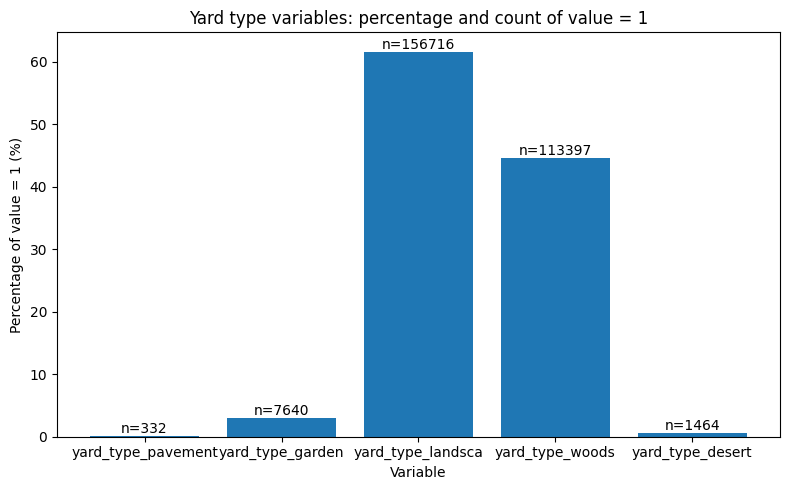

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert ratio to percentage
percent = yard_summary["ratio_1_overall"] * 100

# One single chart, using matplotlib only (no custom colors)
plt.figure(figsize=(8, 5))
bars = plt.bar(yard_summary.index, percent)

plt.xlabel("Variable")
plt.ylabel("Percentage of value = 1 (%)")
plt.title("Yard type variables: percentage and count of value = 1")

plt.xticks(rotation=0, ha="center")

# Annotate each bar with the corresponding count_1
for bar, cnt in zip(bars, yard_summary["count_1"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"n={cnt}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


2.Habitite distribution

In [42]:
print("hab:", hab_cols)
hab_summary = pd.DataFrame({
    "count_1": (df[hab_cols] == 1).sum(),
    "ratio_1_overall": (df[hab_cols] == 1).mean()
})

hab_summary

hab: ['hab_dcid_woods', 'hab_evgr_woods', 'hab_mixed_woods', 'hab_orchard', 'hab_park', 'hab_water_fresh', 'hab_water_salt', 'hab_residential', 'hab_industrial', 'hab_agricultural', 'hab_desert_scrub', 'hab_young_woods', 'hab_swamp', 'hab_marsh']


count_1  ratio_1_overall
hab_dcid_woods     101970         0.400896
hab_evgr_woods      43883         0.172527
hab_mixed_woods    139497         0.548434
hab_orchard         16876         0.066348
hab_park            62569         0.245991
hab_water_fresh    126263         0.496405
hab_water_salt       9036         0.035525
hab_residential    188337         0.740449
hab_industrial      43305         0.170254
hab_agricultural    73307         0.288207
hab_desert_scrub    16723         0.065747
hab_young_woods     60731         0.238765
hab_swamp           40951         0.160999
hab_marsh           29075         0.114309

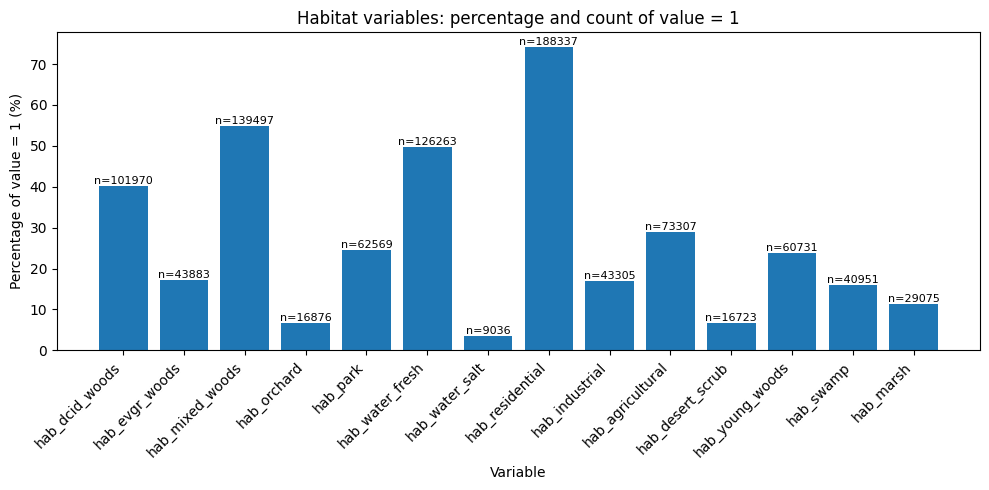

In [43]:
import matplotlib.pyplot as plt

percent = hab_summary["ratio_1_overall"] * 100

plt.figure(figsize=(10, 5))
bars = plt.bar(hab_summary.index, percent)

plt.xlabel("Variable")
plt.ylabel("Percentage of value = 1 (%)")
plt.title("Habitat variables: percentage and count of value = 1")
plt.xticks(rotation=45, ha="right")

for bar, cnt in zip(bars, hab_summary["count_1"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"n={cnt}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()


3.Environmental variable distribution

In [44]:
print("environment:", environment_cols)
for col in environment_cols:
    print("=" * 60)
    print(f"Column: {col}")
    print(df[col].value_counts(dropna=False))

environment: ['evgr_trees_atleast', 'evgr_shrbs_atleast', 'dcid_trees_atleast', 'dcid_shrbs_atleast', 'fru_trees_atleast', 'cacti_atleast', 'brsh_piles_atleast', 'water_srcs_atleast', 'bird_baths_atleast', 'population_atleast', 'count_area_size_sq_m_atleast', 'nearby_feeders', 'housing_density']
Column: evgr_trees_atleast
evgr_trees_atleast
4.0     94767
1.0     64503
11.0    47960
0.0     26482
3.0     20643
Name: count, dtype: int64
Column: evgr_shrbs_atleast
evgr_shrbs_atleast
4.0     95843
1.0     58883
11.0    40571
0.0     40089
3.0     18969
Name: count, dtype: int64
Column: dcid_trees_atleast
dcid_trees_atleast
11.0    107790
4.0      73134
1.0      40674
3.0      23886
0.0       8871
Name: count, dtype: int64
Column: dcid_shrbs_atleast
dcid_shrbs_atleast
11.0    99354
4.0     66882
1.0     46353
0.0     20997
3.0     20769
Name: count, dtype: int64
Column: fru_trees_atleast
fru_trees_atleast
1.0     136035
4.0      50128
0.0      48973
11.0     17113
3.0       2106
Name: count

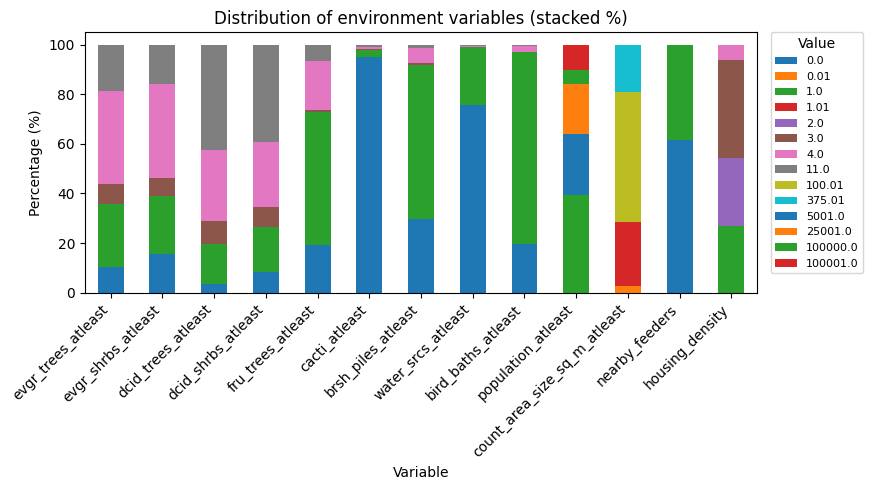

In [45]:
import matplotlib.pyplot as plt

# Keep *_atleast variables + add nearby_feeders and housing_density
cols_to_plot = [c for c in environment_cols if c.endswith("_atleast")] + [
    "nearby_feeders",
    "housing_density"
]

# Build percentage distribution table
dist_table = (
    df[cols_to_plot]
    .apply(lambda s: s.value_counts(normalize=True))
    .fillna(0)
    * 100
)

# Sort the value levels on the x-axis
dist_table = dist_table.sort_index()

# Plot
ax = dist_table.T.plot(
    kind="bar",
    stacked=True,
    figsize=(11, 5)
)

plt.xlabel("Variable")
plt.ylabel("Percentage (%)")
plt.title("Distribution of environment variables (stacked %)")
plt.xticks(rotation=45, ha="right")

# Move legend outside the plot (right side)
plt.legend(
    title="Value",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    fontsize=8
)

# Leave space on the right for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()


4.Disturbance distribution

In [46]:
print("disturbance:", disturbance_cols)
disturbance_summary = pd.DataFrame({
    "count_1": (df[disturbance_cols] == 1).sum(),
    "ratio_1_overall": (df[disturbance_cols] == 1).mean()
})
disturbance_summary


disturbance: ['squirrels', 'cats', 'dogs', 'humans']


count_1  ratio_1_overall
squirrels   209032         0.821812
cats        155848         0.612718
dogs        155140         0.609935
humans      212472         0.835336

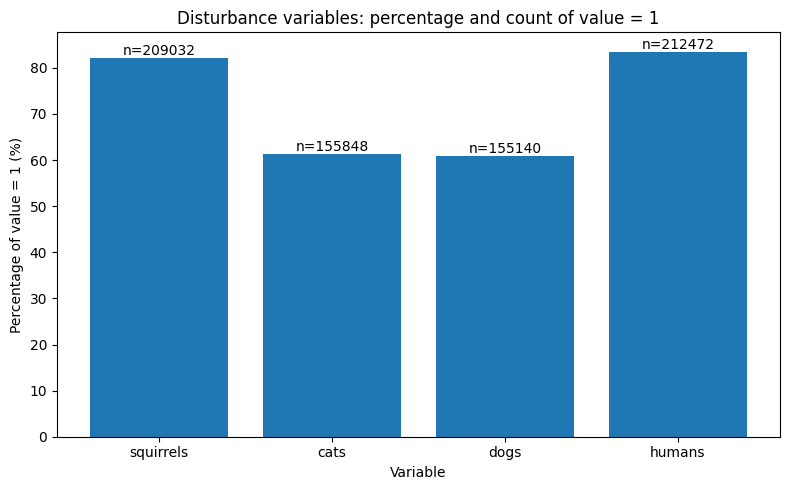

In [47]:
import matplotlib.pyplot as plt

# Convert ratio to percentage
percent = disturbance_summary["ratio_1_overall"] * 100

# One single chart, using matplotlib only (no custom colors)
plt.figure(figsize=(8, 5))
bars = plt.bar(disturbance_summary.index, percent)

plt.xlabel("Variable")
plt.ylabel("Percentage of value = 1 (%)")
plt.title("Disturbance variables: percentage and count of value = 1")



plt.xticks(rotation=0, ha="center")
# Annotate each bar with the corresponding count_1
for bar, cnt in zip(bars, disturbance_summary["count_1"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"n={cnt}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


5.Feed time distribution

In [48]:
print("feeding time:", feeding_time_cols)
feeding_time_summary = pd.DataFrame({
    "count_1": (df[feeding_time_cols] == 1).sum(),
    "ratio_1_overall": (df[feeding_time_cols] == 1).mean()
})

feeding_time_summary


feeding time: ['fed_yr_round', 'fed_in_jan', 'fed_in_feb', 'fed_in_mar', 'fed_in_apr', 'fed_in_may', 'fed_in_jun', 'fed_in_jul', 'fed_in_aug', 'fed_in_sep', 'fed_in_oct', 'fed_in_nov', 'fed_in_dec']


count_1  ratio_1_overall
fed_yr_round    63463         0.249506
fed_in_jan     182951         0.719274
fed_in_feb     182534         0.717635
fed_in_mar     181902         0.715150
fed_in_apr     173608         0.682542
fed_in_may     147446         0.579686
fed_in_jun     133787         0.525985
fed_in_jul     128508         0.505231
fed_in_aug     129258         0.508180
fed_in_sep     142574         0.560532
fed_in_oct     164050         0.644965
fed_in_nov     182886         0.719019
fed_in_dec     182980         0.719388

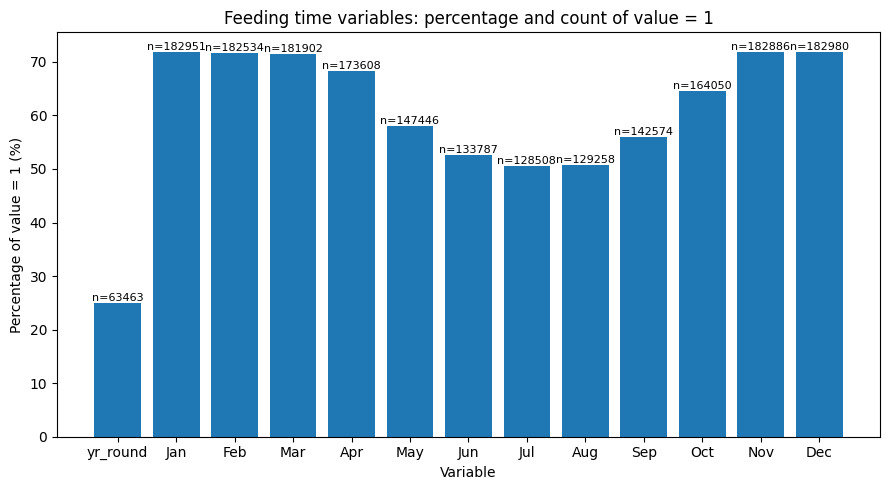

In [49]:
import matplotlib.pyplot as plt

percent = feeding_time_summary["ratio_1_overall"] * 100

plt.figure(figsize=(9, 5))
bars = plt.bar(feeding_time_summary.index, percent)

plt.xlabel("Variable")
plt.ylabel("Percentage of value = 1 (%)")
plt.title("Feeding time variables: percentage and count of value = 1")

# build short labels for x-axis
short_labels = []
for name in feeding_time_summary.index:
    if name == "fed_yr_round":
        short_labels.append("yr_round")
    else:
        # fed_in_jan -> jan -> Jan
        short_labels.append(name.replace("fed_in_", "").capitalize())

plt.xticks(
    ticks=range(len(feeding_time_summary.index)),
    labels=short_labels,
    rotation=0,
    ha="center"
)


for bar, cnt in zip(bars, feeding_time_summary["count_1"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"n={cnt}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()


6.Distribution of the number of different types of feeders

In [50]:
print("num_diff_types_feeder:", feeder_cols)
for col in feeder_cols:
    print("=" * 60)
    print(f"Column: {col}")
    print(df[col].value_counts(dropna=False))


num_diff_types_feeder: ['numfeeders_suet', 'numfeeders_ground', 'numfeeders_hanging', 'numfeeders_platfrm', 'numfeeders_humming', 'numfeeders_water', 'numfeeders_thistle', 'numfeeders_fruit', 'numfeeders_hopper', 'numfeeders_tube', 'numfeeders_other']
Column: numfeeders_suet
numfeeders_suet
1.0        104526
2.0         64283
0.0         47385
3.0         22933
4.0          9137
5.0          3223
6.0          1933
7.0           354
8.0           264
10.0          102
9.0            85
11.0           41
12.0           33
13.0           10
14.0           10
21.0            5
15.0            4
20.0            3
33.0            2
30.0            2
16.0            2
23.0            2
25.0            2
34.0            1
32.0            1
28.0            1
117.0           1
31.0            1
45.0            1
14850.0         1
17.0            1
22.0            1
54.0            1
24.0            1
48.0            1
19.0            1
64.0            1
Name: count, dtype: int64
Column: numfeede

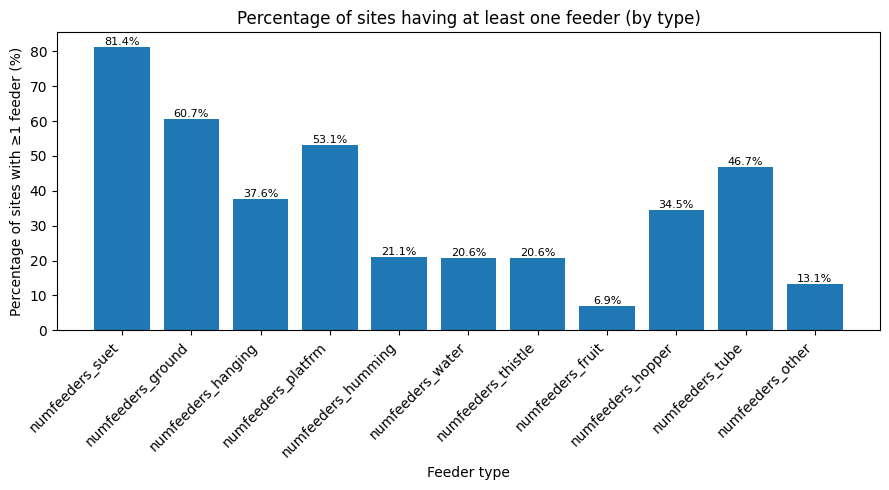

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

has_feeder_ratio = (df[feeder_cols] >= 1).mean() * 100

plt.figure(figsize=(9,5))
bars = plt.bar(has_feeder_ratio.index, has_feeder_ratio.values)

plt.ylabel("Percentage of sites with ≥1 feeder (%)")
plt.xlabel("Feeder type")
plt.title("Percentage of sites having at least one feeder (by type)")

plt.xticks(rotation=45, ha="right")

for bar, val in zip(bars, has_feeder_ratio.values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"{val:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()


##(5)Correlation heatmap

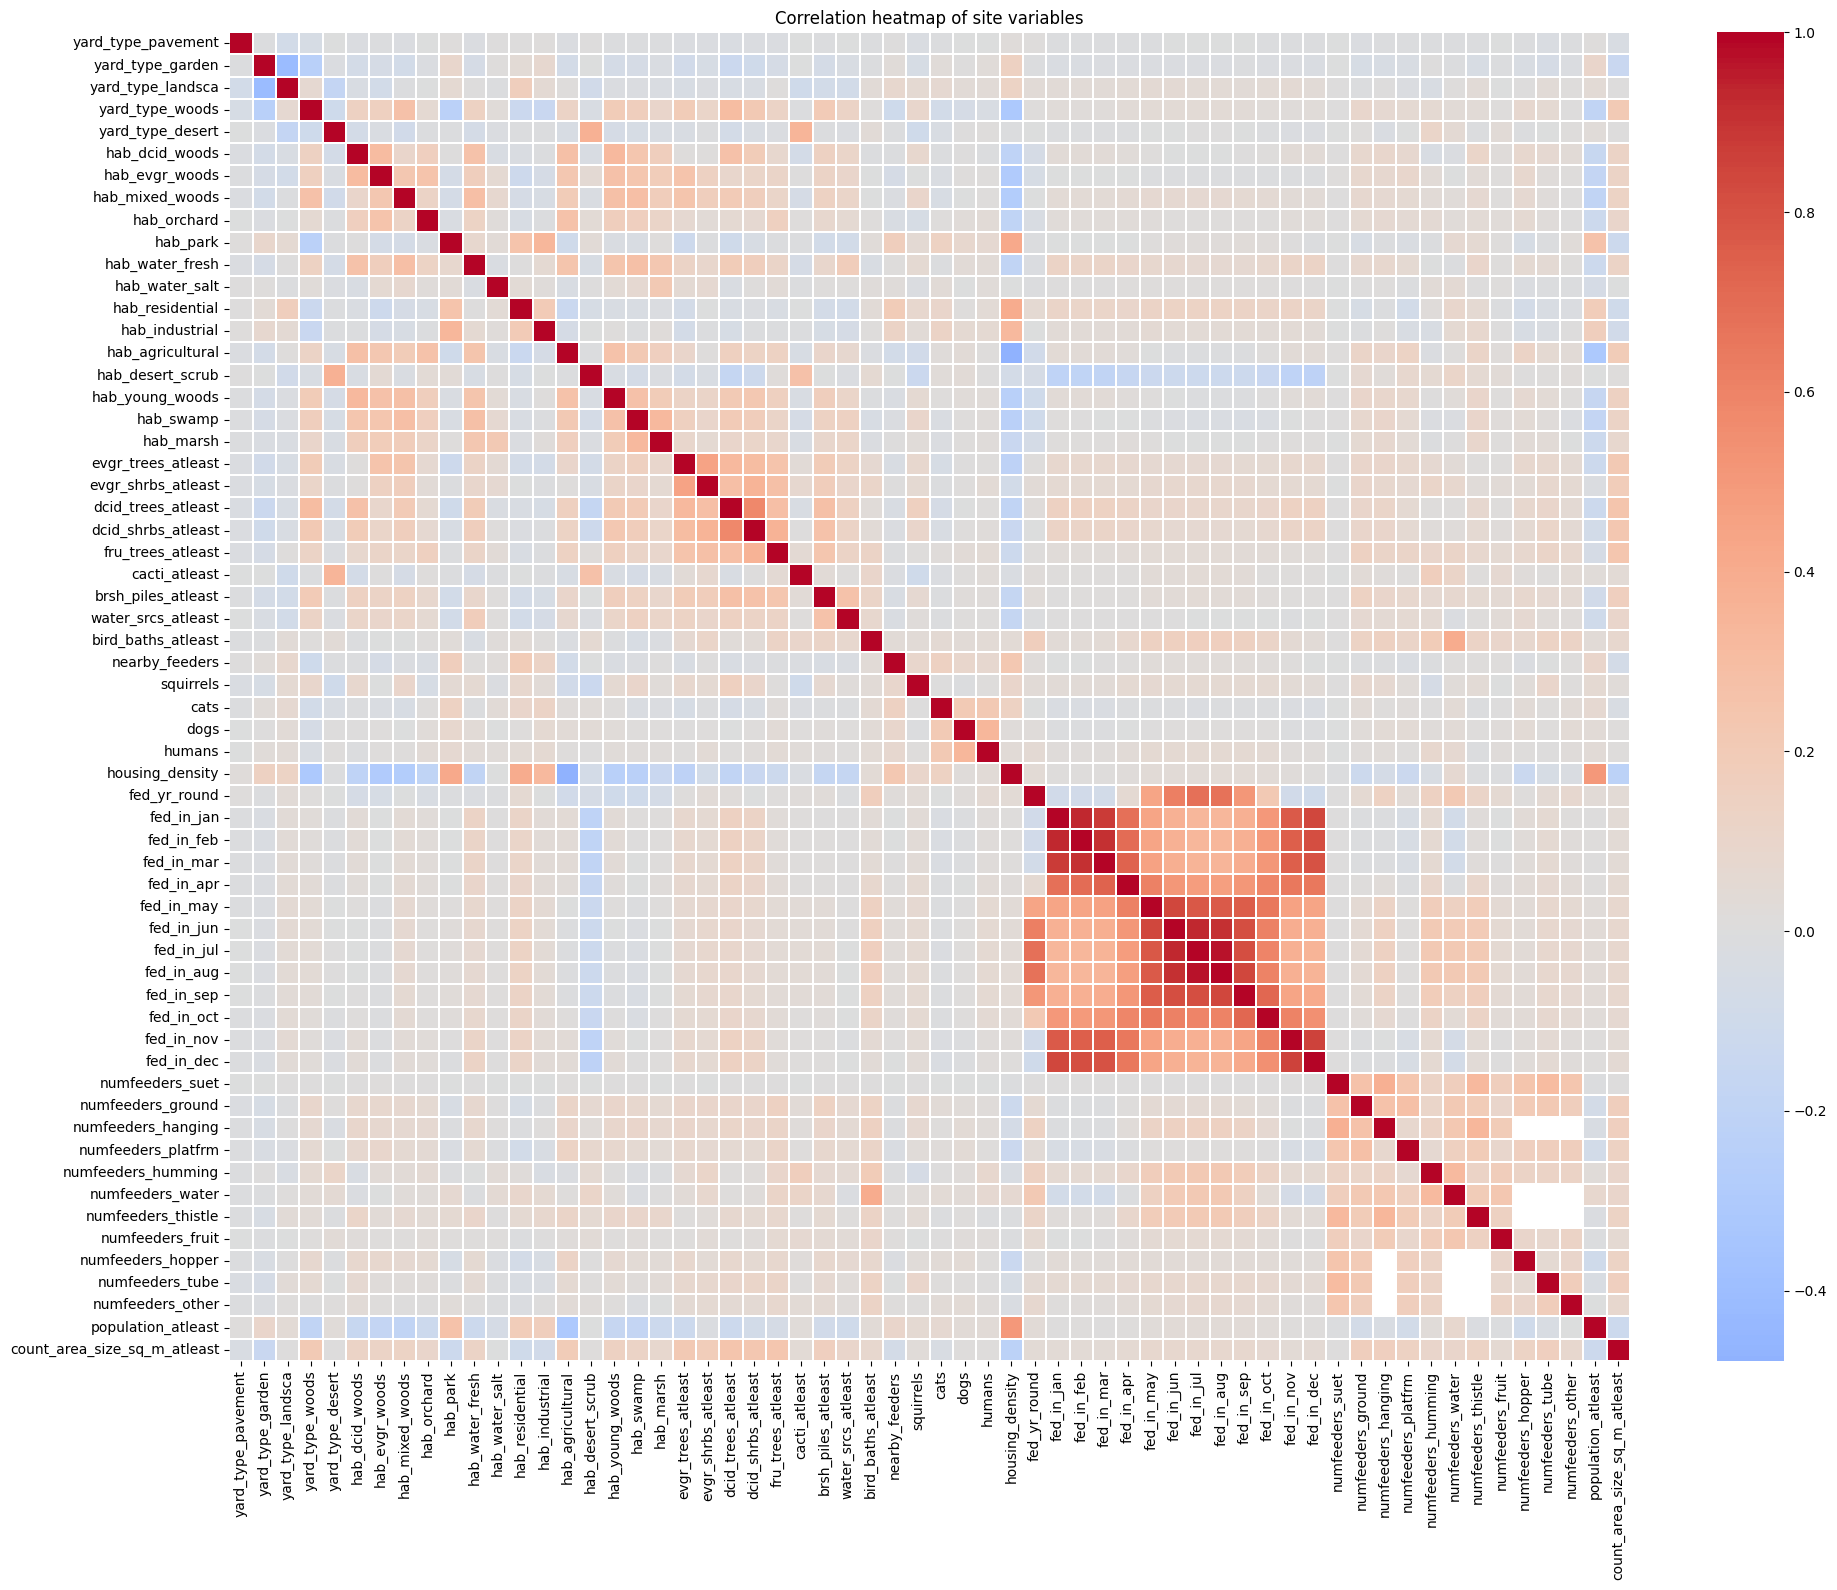

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/PFW_count_site_data_public_2021.csv")

df_num = df.select_dtypes(include="number")

corr = df_num.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.1
)

plt.title("Correlation heatmap of site variables")
plt.tight_layout()
plt.show()


#4.EDA after combining tables  

##(1)merge the datasets in 2 ways

Merge tables by loc_id

In [53]:
import pandas as pd
# df1: observation results

df1 = pd.read_csv("/content/PFW_OBS_clean.csv")

# time rivise
df1["timestamp"] = pd.to_datetime(df1["timestamp"])
df1["Year"] = df1["timestamp"].dt.year

# aggregate to checklist level first
sub_level = (
    df1.groupby(["loc_id", "sub_id"], as_index=False)
       .agg(
           n_species=("species_code", "nunique"),
           total_birds=("how_many", "sum"),
           Year=("Year", "first")
       )
)

# aggregate to site level
site_level = (
    sub_level.groupby("loc_id", as_index=False)
             .agg(
                 avg_species=("n_species", "mean"),
                 avg_birds=("total_birds", "mean"),
                 Year=("Year", "first")
             )
)


# df2: habitat / yard data

df2 = pd.read_csv("/content/PFW_SITE_clean.csv")

# print columns once to check real names
print("df2 columns:", df2.columns.tolist())

# find the proj_period_id column (case-insensitive)
cols_lower = {c.strip().lower(): c for c in df2.columns}
proj_col = cols_lower.get("proj_period_id")

if proj_col is None:
    raise KeyError("Column proj_period_id is not found in df2.")

# keep only PFW_2021 to match df1 (Year = 2021)
df2[proj_col] = df2[proj_col].astype(str).str.strip()
df2_2021 = df2[df2[proj_col] == "PFW_2021"].copy()


# merge by loc_id

merged = site_level.merge(
    df2_2021,
    on="loc_id",
    how="left"
)

# quick alignment check
print("Number of sites in df1:", site_level["loc_id"].nunique())
print("Number of sites in df2 (PFW_2021):", df2_2021["loc_id"].nunique())
print("Number of matched sites:", merged[proj_col].notna().sum())

merged.head()


df2 columns: ['loc_id', 'proj_period_id', 'yard_type_pavement', 'yard_type_garden', 'yard_type_landsca', 'yard_type_woods', 'yard_type_desert', 'hab_dcid_woods', 'hab_evgr_woods', 'hab_mixed_woods', 'hab_orchard', 'hab_park', 'hab_water_fresh', 'hab_water_salt', 'hab_residential', 'hab_industrial', 'hab_agricultural', 'hab_desert_scrub', 'hab_young_woods', 'hab_swamp', 'hab_marsh', 'evgr_trees_atleast', 'evgr_shrbs_atleast', 'dcid_trees_atleast', 'dcid_shrbs_atleast', 'fru_trees_atleast', 'cacti_atleast', 'brsh_piles_atleast', 'water_srcs_atleast', 'bird_baths_atleast', 'nearby_feeders', 'squirrels', 'cats', 'dogs', 'humans', 'housing_density', 'fed_yr_round', 'fed_in_jan', 'fed_in_feb', 'fed_in_mar', 'fed_in_apr', 'fed_in_may', 'fed_in_jun', 'fed_in_jul', 'fed_in_aug', 'fed_in_sep', 'fed_in_oct', 'fed_in_nov', 'fed_in_dec', 'numfeeders_suet', 'numfeeders_ground', 'numfeeders_hanging', 'numfeeders_platfrm', 'numfeeders_humming', 'numfeeders_water', 'numfeeders_thistle', 'numfeeders_fru

loc_id  avg_species  avg_birds  Year proj_period_id  yard_type_pavement  yard_type_garden  yard_type_landsca  yard_type_woods  yard_type_desert  hab_dcid_woods  hab_evgr_woods  \
0    L100032     1.333333   3.166667  2020       PFW_2021                 0.0               0.0                1.0              1.0               0.0             1.0             0.0   
1    L100057     1.555556   6.333333  2020       PFW_2021                 0.0               0.0                1.0              0.0               0.0             0.0             0.0   
2  L10007061     1.000000   2.166667  2020       PFW_2021                 0.0               0.0                1.0              1.0               0.0             1.0             0.0   
3  L10011691     1.100000   4.900000  2020            NaN                 NaN               NaN                NaN              NaN               NaN             NaN             NaN   
4   L1001179     1.000000  10.400000  2021            NaN                 NaN               NaN                NaN              NaN               NaN             NaN             NaN   

   hab_mixed_woods  hab_orchard  hab_park  hab_water_fresh  hab_water_salt  hab_residential  hab_industrial  hab_agricultural  hab_desert_scrub  hab_young_woods  hab_swamp  hab_marsh  \
0              1.0          0.0       0.0              1.0             0.0              1.0             1.0               0.0               0.0              0.0        0.0        0.0   
1              1.0          0.0       0.0              0.0             0.0              1.0             0.0               0.0               0.0              0.0        0.0        0.0   
2              0.0          0.0       0.0              1.0             0.0              1.0             0.0               1.0               0.0              0.0        0.0        0.0   
3              NaN          NaN       NaN              NaN             NaN              NaN             NaN               NaN               NaN              NaN        NaN        NaN   
4              NaN          NaN       NaN              NaN             NaN              NaN             NaN               NaN               NaN              NaN        NaN        NaN   

   evgr_trees_atleast  ...  fed_in_jan  fed_in_feb  fed_in_mar  fed_in_apr  fed_in_may  fed_in_jun  fed_in_jul  fed_in_aug  fed_in_sep  fed_in_oct  fed_in_nov  fed_in_dec  numfeeders_suet  \
0                11.0  ...         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0              1.0   
1                 4.0  ...         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0              1.0   
2                11.0  ...         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0              1.0   
3                 NaN  ...         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN              NaN   
4                 NaN  ...         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN              NaN   

   numfeeders_ground  numfeeders_hanging  numfeeders_platfrm  numfeeders_humming  numfeeders_water  numfeeders_thistle  numfeeders_fruit  numfeeders_hopper  numfeeders_tube  numfeeders_other  \
0                1.0                 0.0                 2.0                 0.0               0.0                 0.0               0.0                1.0              4.0               2.0   
1                3.0                 0.0                 2.0                 1.0               0.0                 0.0               0.0                4.0              2.0               0.0   
2                0.0                 0.0         

In [54]:
merged.to_csv("/content/merged_on_site.csv", index=False)

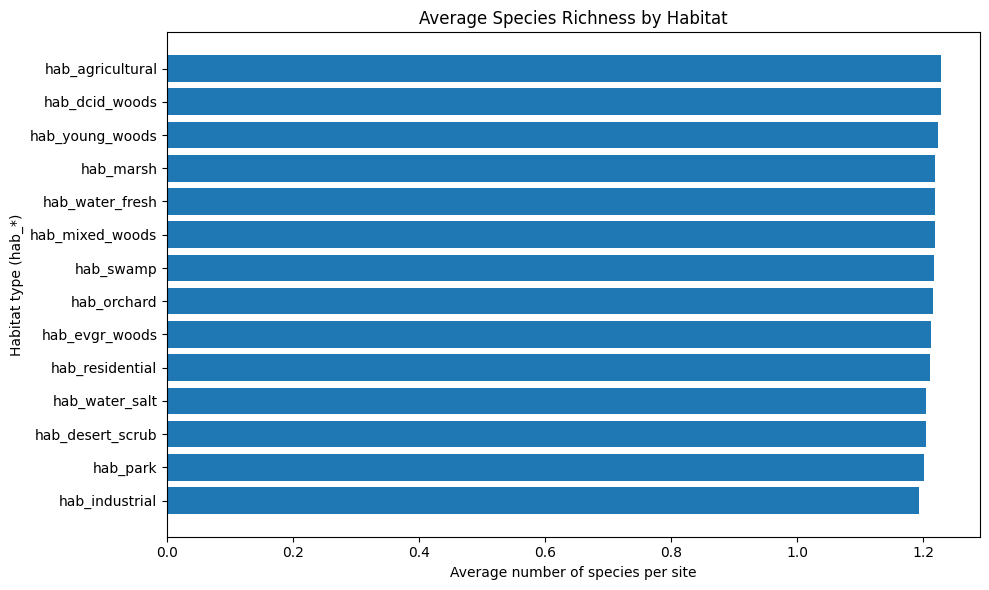

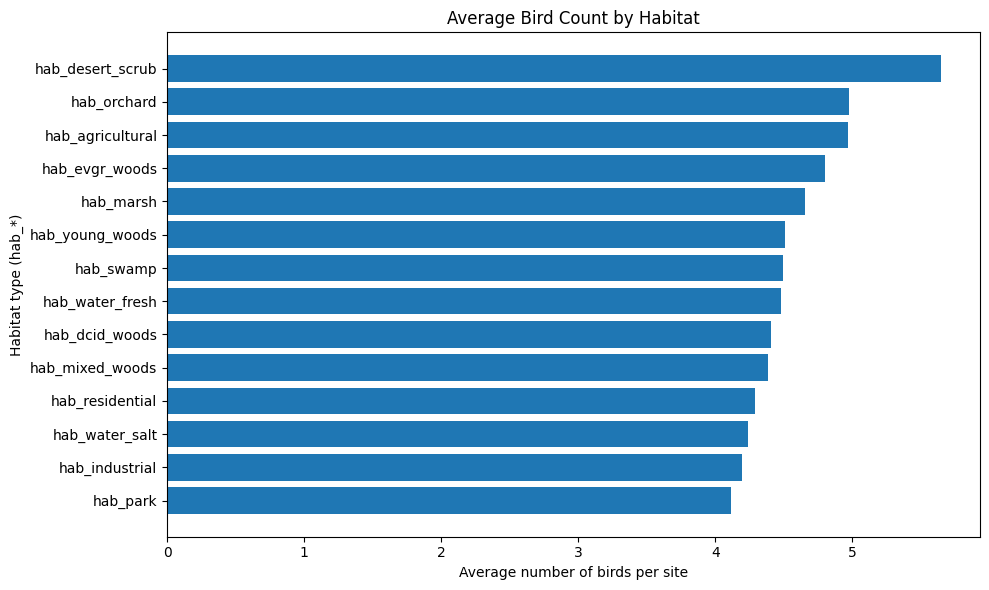

In [55]:
import pandas as pd
import matplotlib.pyplot as plt


# 1) Load merged dataset

merged_path = "/content/merged_on_site.csv"
merged = pd.read_csv(merged_path)


# 2) Identify habitat columns
hab_cols = [c for c in merged.columns if c.lower().startswith("hab_")]


# 3) Build habitat summary
rows = []

for col in hab_cols:
    sub = merged[merged[col] == 1]

    rows.append({
        "habitat": col,
        "avg_species": sub["avg_species"].mean(),
        "avg_birds": sub["avg_birds"].mean(),
        "n_sites": sub.shape[0]
    })

hab_summary = pd.DataFrame(rows)

# Sort for nicer plots
hab_summary_species = hab_summary.sort_values("avg_species", ascending=True)
hab_summary_birds   = hab_summary.sort_values("avg_birds", ascending=True)


# 4) Plot: average species by habitat

plt.figure(figsize=(10, 6))
plt.barh(hab_summary_species["habitat"],
         hab_summary_species["avg_species"])
plt.xlabel("Average number of species per site")
plt.ylabel("Habitat type (hab_*)")
plt.title("Average Species Richness by Habitat")
plt.tight_layout()
plt.show()


# 5) Plot: average birds by habitat
plt.figure(figsize=(10, 6))
plt.barh(hab_summary_birds["habitat"],
         hab_summary_birds["avg_birds"])
plt.xlabel("Average number of birds per site")
plt.ylabel("Habitat type (hab_*)")
plt.title("Average Bird Count by Habitat")
plt.tight_layout()
plt.show()

The average number of species across different habitats was nearly identical, clustering around approximately 1.2 overall. This indicates that habitat type had no discernible effect on species richness within this dataset.  

The average number of birds observed differed markedly between habitats. Sites within desert scrub, agricultural land, and orchards recorded higher average bird counts, whereas parks, industrial estates, and saline water bodies exhibited comparatively lower average bird numbers. This indicates that habitat type strongly influences bird abundance.

Merge by each checklist (observation)

In [56]:
import pandas as pd


# 1. load data
df1 = pd.read_csv("/content/PFW_OBS_clean.csv")
df2 = pd.read_csv("/content/PFW_SITE_clean.csv")

# time rivise
df1["timestamp"] = pd.to_datetime(df1["timestamp"])
df1["Year"] = df1["timestamp"].dt.year

# 2. make column names case-insensitive

df1.columns = df1.columns.str.strip().str.lower()
df2.columns = df2.columns.str.strip().str.lower()


# 3. build proj_period_id in df1
df.rename(columns={"PROJ_PERIOD_ID": "proj_period_id"}, inplace=True)

# 4. make sure join keys exist

required_cols_df1 = {"loc_id", "proj_period_id"}
required_cols_df2 = {"loc_id", "proj_period_id"}

if not required_cols_df1.issubset(df1.columns):
    raise KeyError("df1 is missing join keys.")

if not required_cols_df2.issubset(df2.columns):
    raise KeyError("df2 is missing join keys.")

# 5. merge (keep all df1 rows)

merged_on_checklist = df1.merge(
    df2,
    on=["loc_id", "proj_period_id"],
    how="left",
    suffixes=("", "_site")
)


# 6. quick check
print("rows in df1:", df1.shape[0])
print("rows after merge:", merged_on_checklist.shape[0])

merged_on_checklist.head()

rows in df1: 99343
rows after merge: 99343


loc_id   latitude   longitude subnational1_code           entry_technique     sub_id         obs_id proj_period_id species_code  how_many  valid  reviewed  day1_am  day1_pm  day2_am  day2_pm  \
0    L981010  52.129760 -122.135470             CA-BC  POSTCODE LAT/LONG LOOKUP  S83206450  OBS1092604618       PFW_2021       amegfi        20      1         0        1        0        1        0   
1   L3161698  43.832207 -123.092405             US-OR       /GOOGLE_MAP/ZOOM:18  S78031190  OBS1036509564       PFW_2021       moudov        11      1         0        1        1        1        1   
2  L13210778  39.721470  -75.933660             US-MD       /GOOGLE_MAP/ZOOM:15  S81318993  OBS1073386105       PFW_2021       tuftit         2      1         0        1        1        1        1   
3  L13258348  42.217874  -83.672300             US-MI       /GOOGLE_MAP/ZOOM:15  S79251313  OBS1051702542       PFW_2021       houspa         2      1         0        1        1        1        1   
4    L149639  32.749921  -79.941582             US-SC           PointMaker1.0_2  S79183993  OBS1050809672       PFW_2021       balori        10      1         0        1        1        1        1   

   effort_hrs_atleast  snow_dep_atleast data_entry_method  timestamp  year  yard_type_pavement  yard_type_garden  yard_type_landsca  yard_type_woods  ...  fed_in_jan  fed_in_feb  fed_in_mar  \
0               1.001               5.0     PFW Web 4.1.4 2021-03-04  2021                 0.0               0.0                1.0              0.0  ...         1.0         1.0         1.0   
1               1.001               0.0     PFW Web 4.1.4 2020-12-19  2020                 0.0               0.0                0.0              1.0  ...         1.0         1.0         1.0   
2               8.001               5.0     PFW Web 4.1.4 2021-02-13  2021                 0.0               0.0                1.0              0.0  ...         1.0         1.0         1.0   
3               4.001               0.0     PFW Web 4.1.4 2021-01-13  2021                 0.0               0.0                1.0              1.0  ...         1.0         1.0         1.0   
4               1.001               0.0     PFW Web 4.1.4 2021-01-11  2021                 0.0               0.0                1.0              1.0  ...         1.0         1.0         1.0   

   fed_in_apr  fed_in_may  fed_in_jun  fed_in_jul  fed_in_aug  fed_in_sep  fed_in_oct  fed_in_nov  fed_in_dec  numfeeders_suet  numfeeders_ground  numfeeders_hanging  numfeeders_platfrm  \
0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0              4.0                0.0                 0.0                 0.0   
1         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0              2.0                2.0                 0.0                 2.0   
2         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0              5.0                0.0                 0.0                 0.0   
3         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0              3.0                2.0                 0.0                 1.0   
4         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0              4.0                1.0                 0.0                 1.0   

   numfeeders_humming  numfeeders_water  numfeeders_thistle  numfeeders_fruit  numfeeders_hopper  numfeeders_tube  numfeeders_other  population_atleast  count_area_size_sq_m_atleast  
0                 1.0               0.0                 0.0               0.0                0.0              2.0               0.0                 1.0                        100.01  
1                 2.0               0.0                 0.0               0.0                2.0              4.0               0.0            

In [57]:
merged_on_checklist.to_csv("/content/merged_on_checklist.csv", index=False)

## (2) Top Species Composition Across Habitats  (Within-habitat Proportions)

Top habitats by #observations:
hab_residential 71168
hab_mixed_woods 53314
hab_water_fresh 46914
hab_dcid_woods 37185
hab_park 28770
hab_agricultural 26423
hab_young_woods 25214
hab_swamp 16803

Top species shown: ['norcar', 'dowwoo', 'daejun', 'moudov', 'houfin', 'bkcchi', 'blujay', 'amegfi', 'whbnut', 'tuftit'] ...


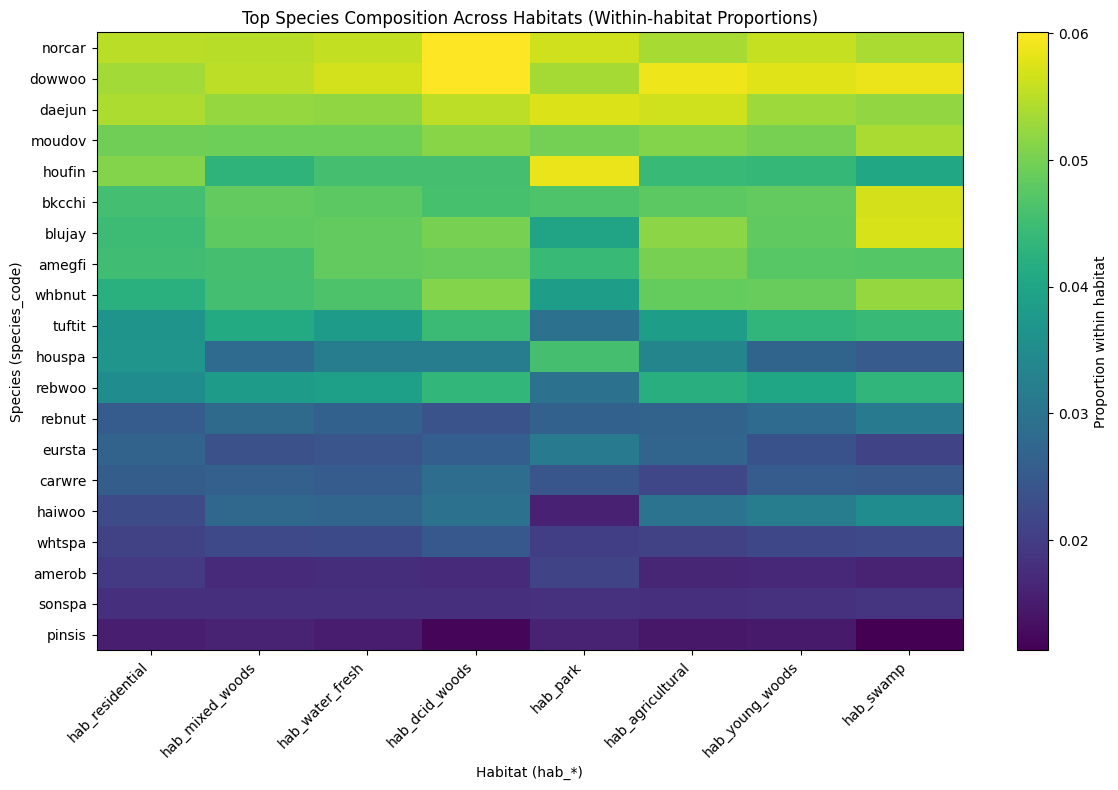

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load observation-level merged dataset
# If your file is in /content, change the path accordingly.
path = "/content/merged_on_checklist.csv"   # <-- change if needed
df = pd.read_csv(path)

# Make column names case-insensitive
df.columns = df.columns.str.strip().str.lower()

# Basic sanity checks
required = {"loc_id", "species_code"}
missing = required - set(df.columns)
if missing:
    raise KeyError(f"Missing required columns: {missing}")


# 2) Identify habitat columns
hab_cols = [c for c in df.columns if c.startswith("hab_")]
if len(hab_cols) == 0:
    raise KeyError("No habitat columns found (hab_*).")

# Optional: keep only valid observations if the column exists
if "valid" in df.columns:
    df = df[df["valid"] == 1].copy()


# 3) Choose top K habitats by number of observations (hab == 1)
K = 8   # number of habitats to compare
hab_sizes = {h: int((df[h] == 1).sum()) for h in hab_cols}
top_habs = sorted(hab_sizes, key=hab_sizes.get, reverse=True)[:K]

print("Top habitats by #observations:")
for h in top_habs:
    print(h, hab_sizes[h])


# 4) Choose top N species overall within selected habitats
N = 20  # number of species to show

df_sel = df[df[top_habs].eq(1).any(axis=1)].copy()
top_species = df_sel["species_code"].value_counts().head(N).index.tolist()

print("\nTop species shown:", top_species[:10], "...")


# 5) Build a species x habitat matrix of within-habitat proportions
#    proportion = count(species in habitat) / total observations in habitat

mat = []
for h in top_habs:
    sub = df[df[h] == 1]
    denom = len(sub)
    counts = sub["species_code"].value_counts()
    row = [(counts.get(sp, 0) / denom) if denom > 0 else 0 for sp in top_species]
    mat.append(row)

# mat currently: habitats x species -> convert to species x habitats
mat = np.array(mat).T

heat_df = pd.DataFrame(mat, index=top_species, columns=top_habs)


# 6) Plot heatmap (matplotlib only)

plt.figure(figsize=(12, 8))
im = plt.imshow(heat_df.values, aspect="auto")  # no manual colors

plt.colorbar(im, label="Proportion within habitat")

plt.xticks(ticks=np.arange(len(top_habs)), labels=top_habs, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_species)), labels=top_species)

plt.title("Top Species Composition Across Habitats (Within-habitat Proportions)")
plt.xlabel("Habitat (hab_*)")
plt.ylabel("Species (species_code)")
plt.tight_layout()
plt.show()


##(3)Distribution of Log-Transformed Feeding Intensity

In [59]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Rename the column PROJ_PERIOD_ID in df_pfw to proj_period_id

df_site = pd.read_csv("/content/PFW_SITE_clean.csv")
df_pfw = pd.read_csv("/content/PFW_OBS_clean.csv")

df_pfw = df_pfw.rename(columns={'PROJ_PERIOD_ID': 'proj_period_id'})

# Merge df_pfw and df_site on loc_id and proj_period_id
df_merged = pd.merge(df_pfw, df_site, on=['loc_id', 'proj_period_id'], how='inner')

# Print the shape of df_merged
print(f"Shape of df_merged: {df_merged.shape}")

# Display the first 5 rows of df_merged
print("First 5 rows of df_merged:")
display(df_merged.head())

# Compute and print the descriptive statistics
print("Descriptive statistics for numerical columns:")
display(df_merged.describe())

# Define feeder columns for calculations
feeder_cols = [col for col in df_merged.columns if col.startswith('numfeeders_')]

# Calculate feeding_variety for the merged dataframe
df_merged['feeding_variety'] = (
    df_merged[feeder_cols]
    .fillna(0)
    .gt(0)
    .sum(axis=1) / len(feeder_cols)
)

Shape of df_merged: (76981, 80)
First 5 rows of df_merged:


loc_id   latitude   longitude subnational1_code           entry_technique     sub_id         obs_id proj_period_id species_code  how_many  valid  reviewed  day1_am  day1_pm  day2_am  day2_pm  \
0    L981010  52.129760 -122.135470             CA-BC  POSTCODE LAT/LONG LOOKUP  S83206450  OBS1092604618       PFW_2021       amegfi        20      1         0        1        0        1        0   
1   L3161698  43.832207 -123.092405             US-OR       /GOOGLE_MAP/ZOOM:18  S78031190  OBS1036509564       PFW_2021       moudov        11      1         0        1        1        1        1   
2  L13210778  39.721470  -75.933660             US-MD       /GOOGLE_MAP/ZOOM:15  S81318993  OBS1073386105       PFW_2021       tuftit         2      1         0        1        1        1        1   
3  L13258348  42.217874  -83.672300             US-MI       /GOOGLE_MAP/ZOOM:15  S79251313  OBS1051702542       PFW_2021       houspa         2      1         0        1        1        1        1   
4    L149639  32.749921  -79.941582             US-SC           PointMaker1.0_2  S79183993  OBS1050809672       PFW_2021       balori        10      1         0        1        1        1        1   

   effort_hrs_atleast  snow_dep_atleast Data_Entry_Method   timestamp  yard_type_pavement  yard_type_garden  yard_type_landsca  yard_type_woods  yard_type_desert  ...  fed_in_jan  fed_in_feb  \
0               1.001               5.0     PFW Web 4.1.4  2021-03-04                 0.0               0.0                1.0              0.0               0.0  ...         1.0         1.0   
1               1.001               0.0     PFW Web 4.1.4  2020-12-19                 0.0               0.0                0.0              1.0               0.0  ...         1.0         1.0   
2               8.001               5.0     PFW Web 4.1.4  2021-02-13                 0.0               0.0                1.0              0.0               0.0  ...         1.0         1.0   
3               4.001               0.0     PFW Web 4.1.4  2021-01-13                 0.0               0.0                1.0              1.0               0.0  ...         1.0         1.0   
4               1.001               0.0     PFW Web 4.1.4  2021-01-11                 0.0               0.0                1.0              1.0               0.0  ...         1.0         1.0   

   fed_in_mar  fed_in_apr  fed_in_may  fed_in_jun  fed_in_jul  fed_in_aug  fed_in_sep  fed_in_oct  fed_in_nov  fed_in_dec  numfeeders_suet  numfeeders_ground  numfeeders_hanging  numfeeders_platfrm  \
0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0              4.0                0.0                 0.0                 0.0   
1         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0              2.0                2.0                 0.0                 2.0   
2         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0              5.0                0.0                 0.0                 0.0   
3         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0              3.0                2.0                 0.0                 1.0   
4         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0         1.0              4.0                1.0                 0.0                 1.0   

   numfeeders_humming  numfeeders_water  numfeeders_thistle  numfeeders_fruit  numfeeders_hopper  numfeeders_tube  numfeeders_other  population_atleast  count_area_size_sq_m_atleast  
0                 1.0               0.0                 0.0               0.0                0.0              2.0               0.0                 1.0                        100.01  
1                 2.0               0.0                 0.0      

Descriptive statistics for numerical columns:


latitude     longitude      how_many    valid      reviewed       day1_am       day1_pm       day2_am       day2_pm  effort_hrs_atleast  snow_dep_atleast  yard_type_pavement  \
count  76981.000000  76981.000000  76981.000000  76981.0  76981.000000  76981.000000  76981.000000  76981.000000  76981.000000        76981.000000      76981.000000        76981.000000   
mean      40.671891    -87.131246      3.654109      1.0      0.003663      0.918318      0.803276      0.900755      0.788987            1.788909          1.896973            0.001221   
std        4.589700     16.032421      6.292540      0.0      0.060414      0.273882      0.397524      0.298993      0.408030            1.918271          4.391181            0.034923   
min       21.422854   -157.949318      1.000000      1.0      0.000000      0.000000      0.000000      0.000000      0.000000            0.001000          0.000000            0.000000   
25%       38.264379    -93.346947      1.000000      1.0      0.000000      1.000000      1.000000      1.000000      1.000000            1.001000          0.000000            0.000000   
50%       41.072853    -80.626197      2.000000      1.0      0.000000      1.000000      1.000000      1.000000      1.000000            1.001000          0.000000            0.000000   
75%       43.306680    -76.164731      4.000000      1.0      0.000000      1.000000      1.000000      1.000000      1.000000            1.001000          0.001000            0.000000   
max       64.933982    -52.745790    500.000000      1.0      1.000000      1.000000      1.000000      1.000000      1.000000            8.001000         15.001000            1.000000   

       yard_type_garden  yard_type_landsca  yard_type_woods  yard_type_desert  hab_dcid_woods  hab_evgr_woods  hab_mixed_woods   hab_orchard      hab_park  hab_water_fresh  hab_water_salt  \
count      76981.000000       76981.000000     76981.000000      76981.000000    76981.000000    76981.000000     76981.000000  76981.000000  76981.000000     76981.000000    76981.000000   
mean           0.031021           0.877268         0.694639          0.008236        0.483041        0.170510         0.692561      0.082319      0.373729         0.609423        0.039101   
std            0.173375           0.328131         0.460563          0.090377        0.499716        0.376082         0.461436      0.274852      0.483796         0.487883        0.193835   
min            0.000000           0.000000         0.000000          0.000000        0.000000        0.000000         0.000000      0.000000      0.000000         0.000000        0.000000   
25%            0.000000           1.000000         0.000000          0.000000        0.000000        0.000000         0.000000      0.000000      0.000000         0.000000        0.000000   
50%            0.000000           1.000000         1.000000          0.000000        0.000000        0.000000         1.000000      0.000000      0.000000         1.000000        0.000000   
75%            0.000000           1.000000         1.000000          0.000000        1.000000        0.000000         1.000000      0.000000      1.000000         1.000000        0.000000   
max            1.000000           1.000000         1.000000          1.000000        1.000000        1.000000         1.000000      1.000000      1.000000         1.000000        1.000000   

       hab_residential  hab_industrial  ...    fed_in_jan    fed_in_feb    fed_in_mar    fed_in_apr    fed_in_may    fed_in_jun    fed_in_jul    fed_in_aug    fed_in_sep    fed_in_oct    fed_in_nov  \
count     76981.000000    76981.000000  ...  76981.000000  76981.000000  76981.000000  76981.000000  76981.000000  76981.000000  76981.000000  76981.000000  76981.000000  76981.000000  76981.000000   
mean          0.924488        0.204544  ...      0.964082      0.961029      0.963640      0.953326      0.899638      0.863382      0.849236      0.850392      0.878554      0.930996      0.98158

In [60]:
tmp = df_merged.copy()
feeder_cols = [col for col in tmp.columns if col.startswith('numfeeders_')]
month_cols = [col for col in tmp.columns if col.startswith('fed_in_')]

tmp['feeding_intensity'] = tmp[feeder_cols].fillna(0).sum(axis=1)
tmp['feeding_diversity'] = tmp[feeder_cols].fillna(0).gt(0).sum(axis=1)
tmp['feeding_consistency'] = tmp[month_cols].fillna(0).gt(0).sum(axis=1)

site_period = (
    tmp.groupby(['loc_id', 'proj_period_id'])
       .agg(**{
           'feeding_intensity': ('feeding_intensity', 'mean'),
           'feeding_diversity': ('feeding_diversity', 'mean'),
           'feeding_variety': ('feeding_variety', 'mean'),
           'feeding_consistency': ('feeding_consistency', 'mean'),
           'avg_bird_count': ('how_many', 'mean'),
           'n_checklists': ('obs_id', 'nunique'),
           'avg_effort_hrs': ('effort_hrs_atleast', 'mean')
       })
       .reset_index()
)


print("")
display(site_period.head())

loc_id proj_period_id  feeding_intensity  feeding_diversity  feeding_variety  feeding_consistency  avg_bird_count  n_checklists  avg_effort_hrs
0    L100032       PFW_2021               11.0                6.0         0.545455                 12.0        2.375000             8        1.001000
1    L100057       PFW_2021               13.0                6.0         0.545455                 12.0        4.071429            14        3.143857
2  L10007061       PFW_2021                4.0                3.0         0.272727                 12.0        2.166667             6        1.001000
3  L10011987       PFW_2021                9.0                4.0         0.363636                 12.0        4.200000            10        2.501000
4    L100209       PFW_2021                4.0                4.0         0.363636                 12.0        3.000000             7        1.858143

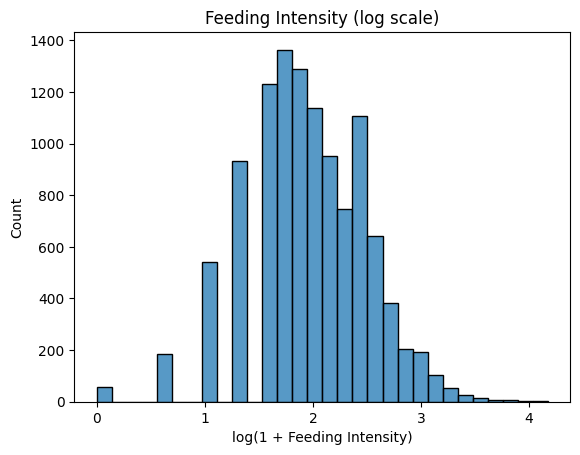

In [61]:
site_period['intensity_log'] = np.log1p(site_period['feeding_intensity'])
sns.histplot(site_period['intensity_log'], bins=30)
plt.title("Feeding Intensity (log scale)")
plt.xlabel("log(1 + Feeding Intensity)")
plt.show()

In the original data, most sites exhibited relatively low feeding intensity, but a few sites fed extremely frequently, causing most observations to cluster together and obscuring the overall pattern. Therefore, I applied a log(1 + x) transformation. This compressed the scale of high-intensity feeding values while preserving the relative differences between low-intensity feedings. The transformed distribution is more concentrated (with values roughly between 1.5 and 2.5), closer to symmetry, and easier to visualize and analyze further.

#5.Analysis experiments

##(1).Distribution Analysis of Numerical Site Features（Kush）

In [62]:
df_merged = pd.read_csv("/content/PFW_SITE_clean.csv")

In [63]:
numerical_cols = df_merged.select_dtypes(include=['int64', 'float64']).columns

# Filter out columns with 2 or fewer unique values as they are likely binary or very low cardinality
# and histograms won't be informative for distribution analysis
filtered_numerical_cols = [col for col in numerical_cols if df_merged[col].nunique() > 2]

print("Selected numerical columns for distribution analysis:")
print(filtered_numerical_cols)

Selected numerical columns for distribution analysis:
['evgr_trees_atleast', 'evgr_shrbs_atleast', 'dcid_trees_atleast', 'dcid_shrbs_atleast', 'fru_trees_atleast', 'cacti_atleast', 'brsh_piles_atleast', 'water_srcs_atleast', 'bird_baths_atleast', 'housing_density', 'numfeeders_suet', 'numfeeders_ground', 'numfeeders_hanging', 'numfeeders_platfrm', 'numfeeders_humming', 'numfeeders_water', 'numfeeders_thistle', 'numfeeders_fruit', 'numfeeders_hopper', 'numfeeders_tube', 'numfeeders_other', 'population_atleast', 'count_area_size_sq_m_atleast']


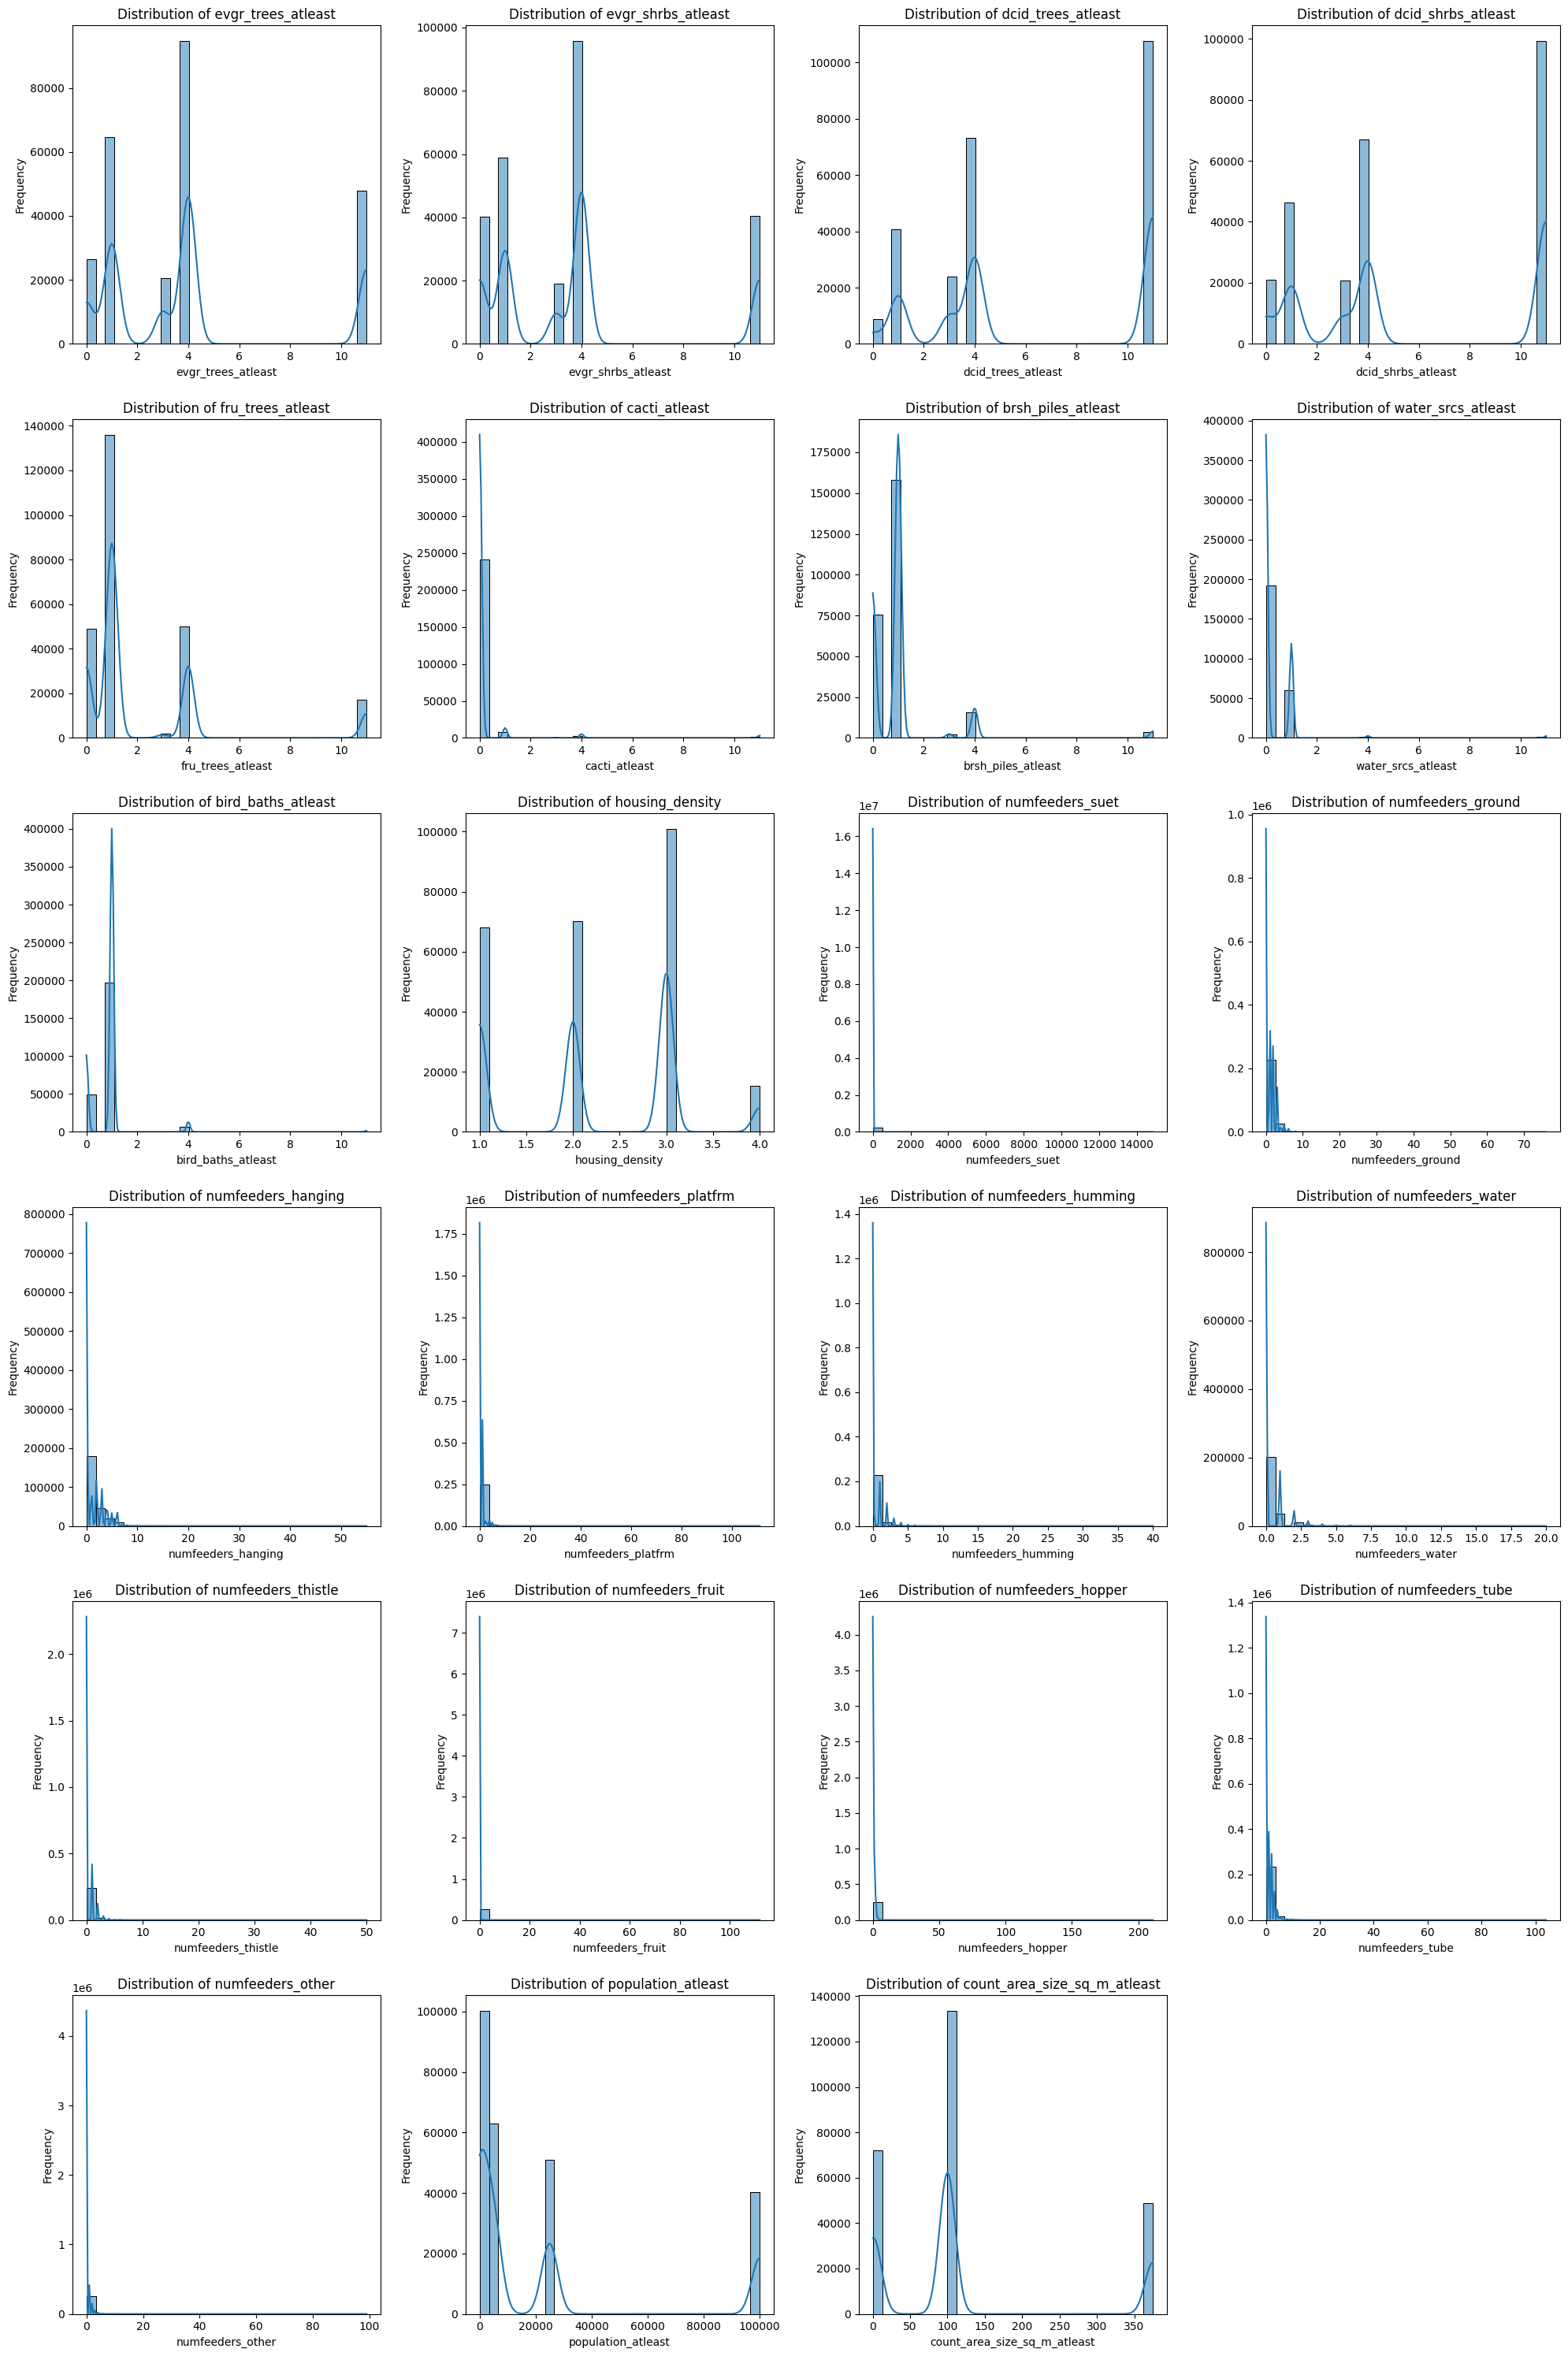

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Determine the number of rows and columns for subplots
num_cols = len(filtered_numerical_cols)
num_rows = int(np.ceil(num_cols / 4)) # 4 plots per row

plt.figure(figsize=(20, 5 * num_rows))

for i, col in enumerate(filtered_numerical_cols):
    plt.subplot(num_rows, 4, i + 1) # Create subplots in a grid
    sns.histplot(df_merged[col].dropna(), kde=True, bins=30) # Plot histogram with KDE
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Started by loading the merged bird-feeder site dataset and focusing on getting a thorough understanding of its numerical variables before any deeper analysis. The first step was to identify all numerical columns using select_dtypes, but rather than plotting every single one, they were filtered down to only those with more than 2 unique values. The reasoning was simple: columns with just 2 unique values are essentially binary flags, and plotting a histogram or KDE for them doesn't reveal anything meaningful about a distribution. By filtering those out, it was ensured that every plot generated was actually worth examining.

Once the refined list of numerical columns was obtained, a grid of subplots was built, with 4 plots per row. For each column, a histogram with a KDE overlay was generated using seaborn's histplot. This combination was deliberate: the histogram shows the raw frequency of values across bins, while the KDE provides a smooth curve that helps visualize the overall shape of the distribution at a glance. Together, they allow immediate assessment of whether a variable is skewed or symmetric, where the bulk of observations are concentrated, how spread out the values are, and whether there are any outliers or unusual patterns that might need attention later. This step provided the grounding needed to make informed decisions about feature selection and transformations heading into the clustering work.

##(2).Distribution Analysis of Categorical Site Features （Kush）

In [65]:
categorical_cols = []

# Add object type columns, excluding identifiers
object_cols = df_merged.select_dtypes(include='object').columns
exclude_object_cols = ['loc_id', 'sub_id', 'obs_id', 'PROJ_PERIOD_ID']
for col in object_cols:
    if col not in exclude_object_cols:
        categorical_cols.append(col)

# Add numerical columns with unique values > 2 and < 20, excluding 'Year', 'Month', and those already identified as binary
# Also exclude latitude and longitude as they are numerical identifiers and not categorical
numerical_cols = df_merged.select_dtypes(include=['int64', 'float64']).columns
exclude_numerical_cols_from_categorical = ['Year', 'latitude', 'longitude']

for col in numerical_cols:
    if col not in exclude_numerical_cols_from_categorical:
        num_unique = df_merged[col].nunique()
        # Include columns with 3 to 19 unique values for categorical analysis
        if num_unique > 2 and num_unique < 20:
            if col not in categorical_cols: # Avoid duplicates if already added from object_cols
                categorical_cols.append(col)

# Ensure 'Month' is included if it meets the criteria and wasn't already
if 'Month' in numerical_cols and df_merged['Month'].nunique() > 2 and 'Month' not in categorical_cols:
    categorical_cols.append('Month')

# Sort for consistent plotting order
categorical_cols.sort()

print("Identified Categorical Columns for Distribution Analysis:")
print(categorical_cols)

Identified Categorical Columns for Distribution Analysis:
['bird_baths_atleast', 'brsh_piles_atleast', 'cacti_atleast', 'count_area_size_sq_m_atleast', 'dcid_shrbs_atleast', 'dcid_trees_atleast', 'evgr_shrbs_atleast', 'evgr_trees_atleast', 'fru_trees_atleast', 'housing_density', 'numfeeders_water', 'population_atleast', 'proj_period_id', 'water_srcs_atleast']


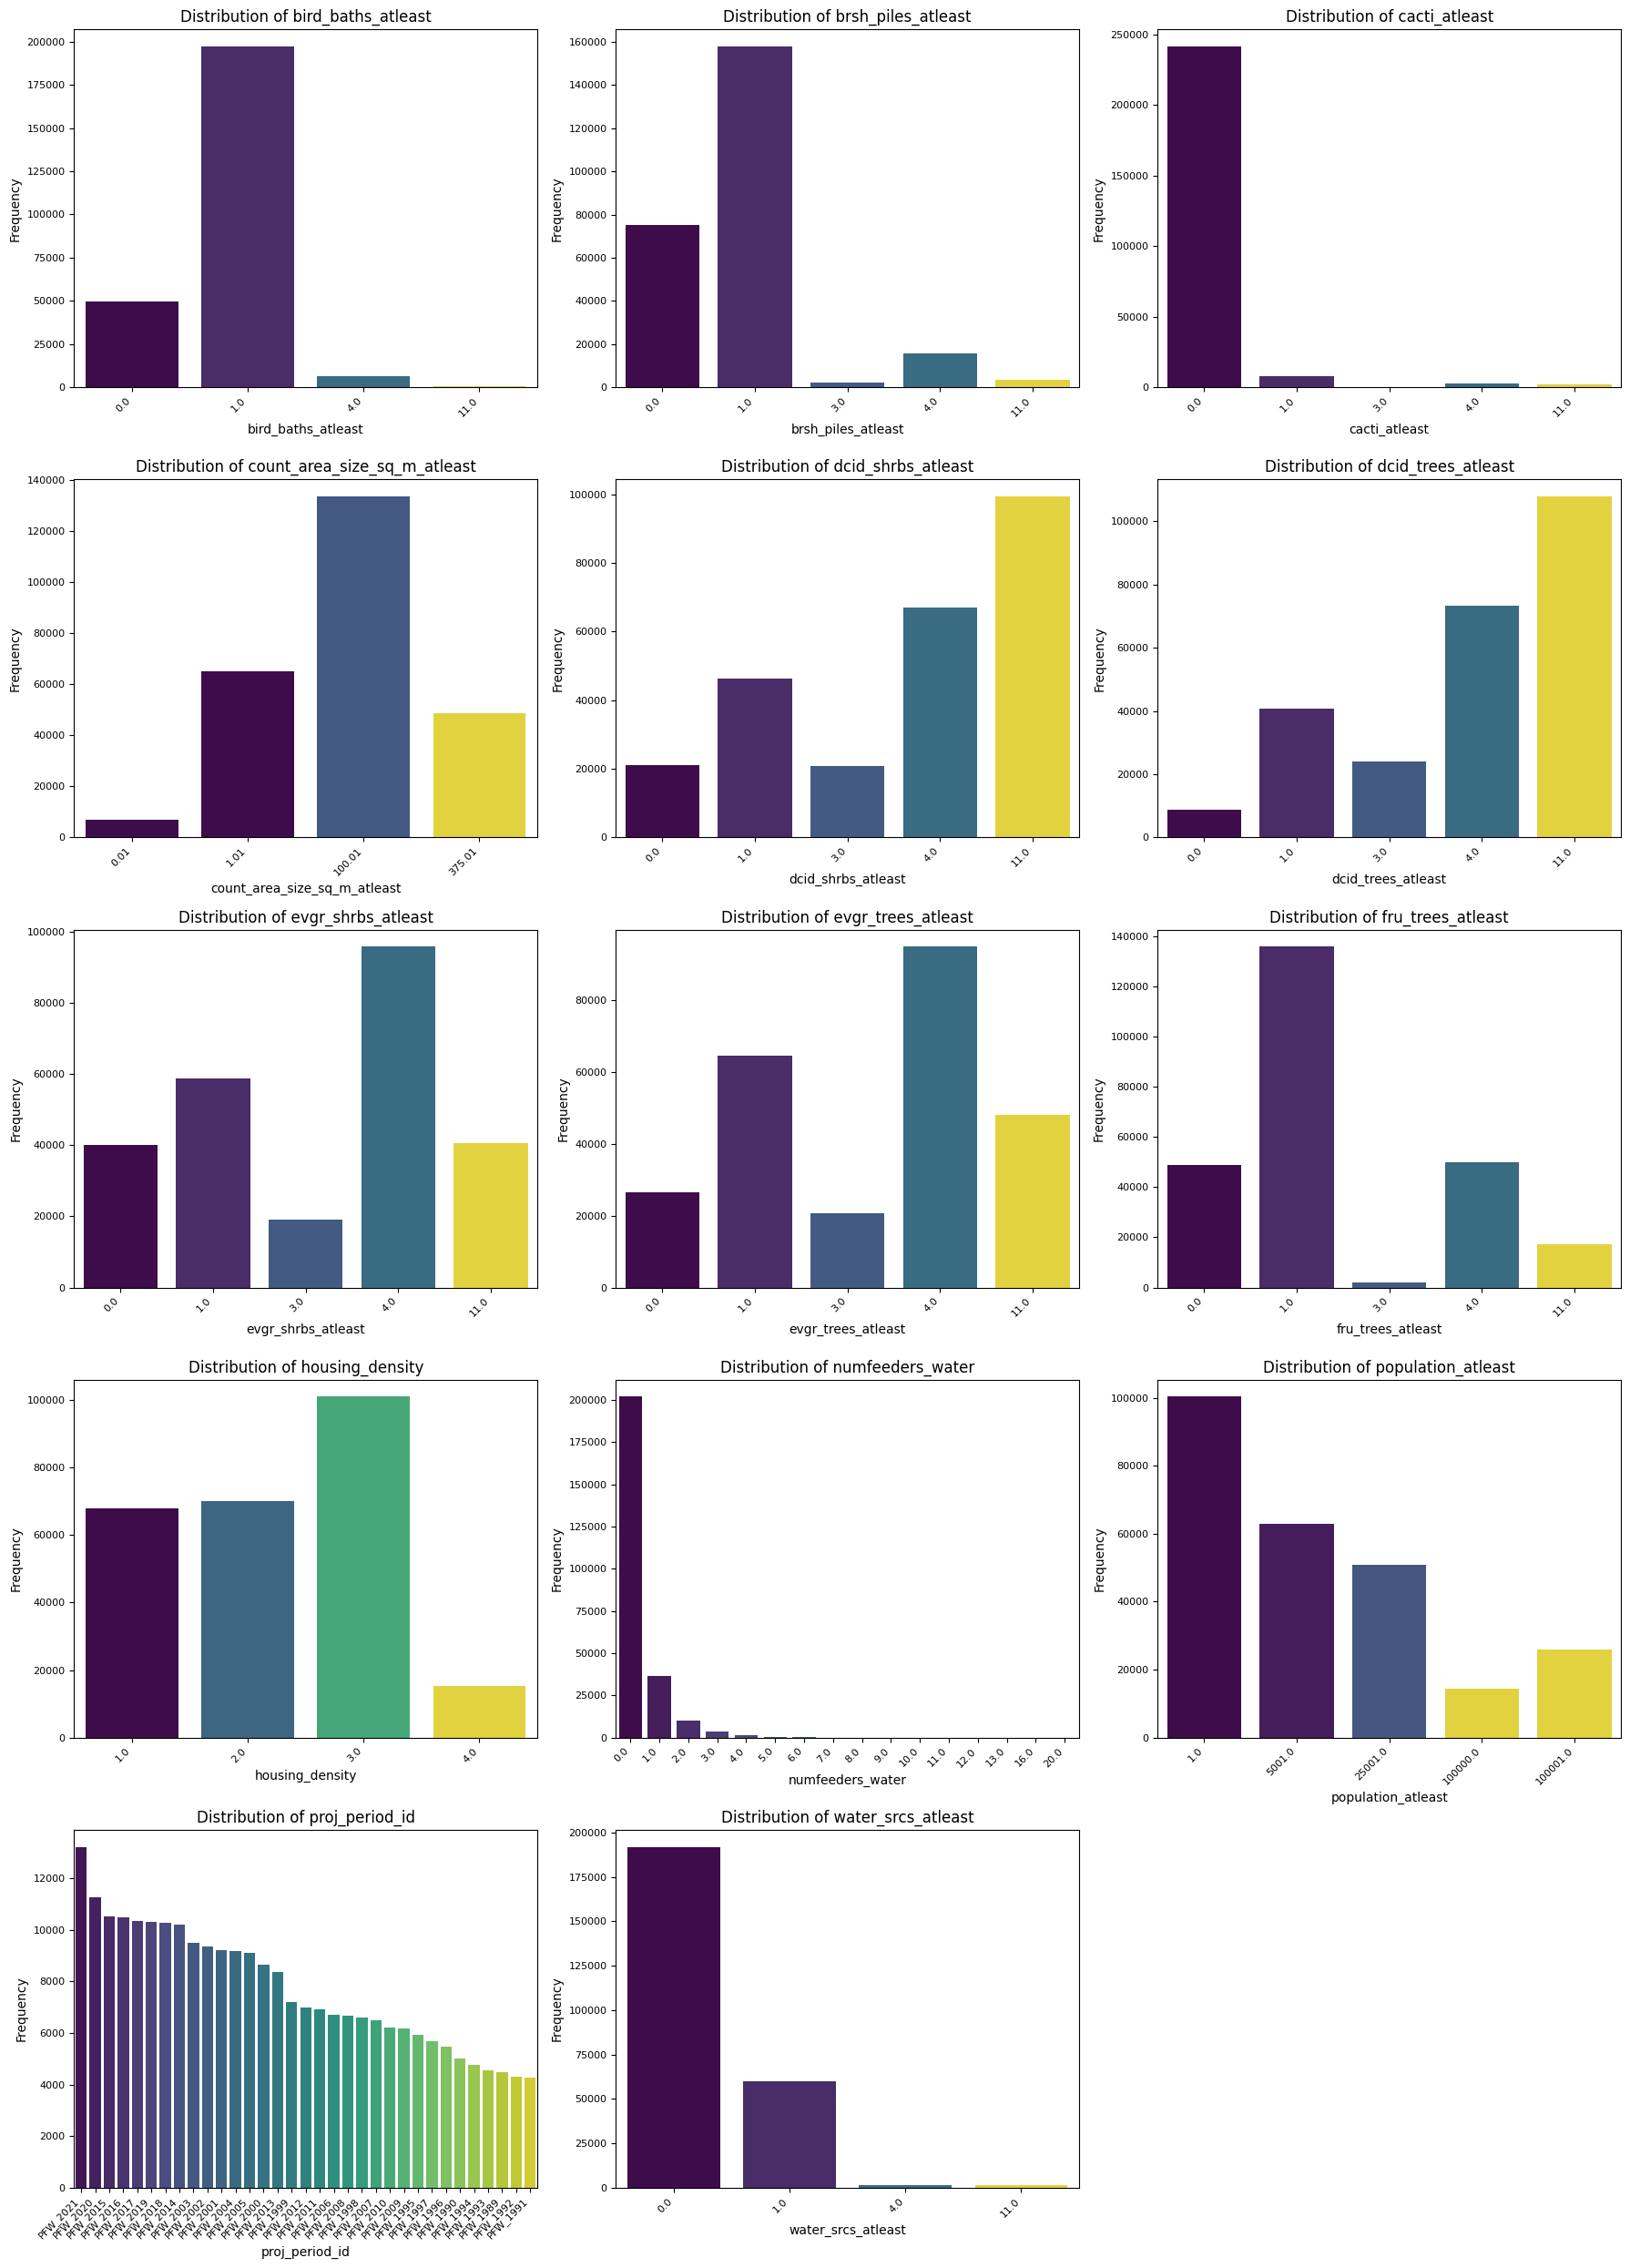

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Determine the number of rows and columns for subplots dynamically
# We will aim for a maximum of 3 plots per row for better readability
num_plots = len(categorical_cols)
num_cols_grid = 3
num_rows_grid = int(np.ceil(num_plots / num_cols_grid))

plt.figure(figsize=(num_cols_grid * 6, num_rows_grid * 5))

for i, col in enumerate(categorical_cols):
    plt.subplot(num_rows_grid, num_cols_grid, i + 1)

    # Get value counts, including NaN values
    value_counts = df_merged[col].value_counts(dropna=False)

    # Create a bar plot
    sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis', hue=value_counts.index, legend=False)

    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

In my second section, I shifted focus toward understanding the categorical structure of the dataset, and then feeding into the broader clustering pipeline. I identified categorical columns by combining object-type columns (excluding identifier fields like loc_id, sub_id, etc.) with numerical columns that had between 3 and 19 unique values, a range where bar chart distributions are genuinely informative. I also made sure Month was captured separately since it's a meaningful cyclical variable. I then plotted frequency bar charts for each of these columns in a clean 3-column grid, with rotated x-axis labels for readability.

On the clustering side, the feeding behavior features, feeding_intensity, feeding_variety, and feeding_consistency, were standardized using StandardScaler to ensure no single variable dominated by scale. For hierarchical clustering, I used Ward's method, which minimizes within-cluster variance at each merge step. After inspecting the dendrogram, I cut the tree at k = 5, giving me five interpretable groups stored in a cluster_hc column. I then validated the split by checking cluster counts to ensure a reasonably balanced distribution across groups.

For K-Means, I evaluated multiple values of k using both the Elbow method (via KElbowVisualizer with distortion scores over k = 3 to 20) and silhouette scores across k = 2 through 8. Both pointed to k = 3 as the optimal number of clusters. I fitted K-Means with n_clusters=3 and visualized how avg_bird_count varied across the three resulting feeding strategy clusters using boxplots, capping the y-axis at the 95th percentile to keep the comparison clean and unaffected by extreme outliers.

##(3) Clustering Feeding Behavior Patterns Using KMeans and Hierarchical Methods （Yiheng）


In [67]:
site_period.to_csv("site_period.csv", index=False)

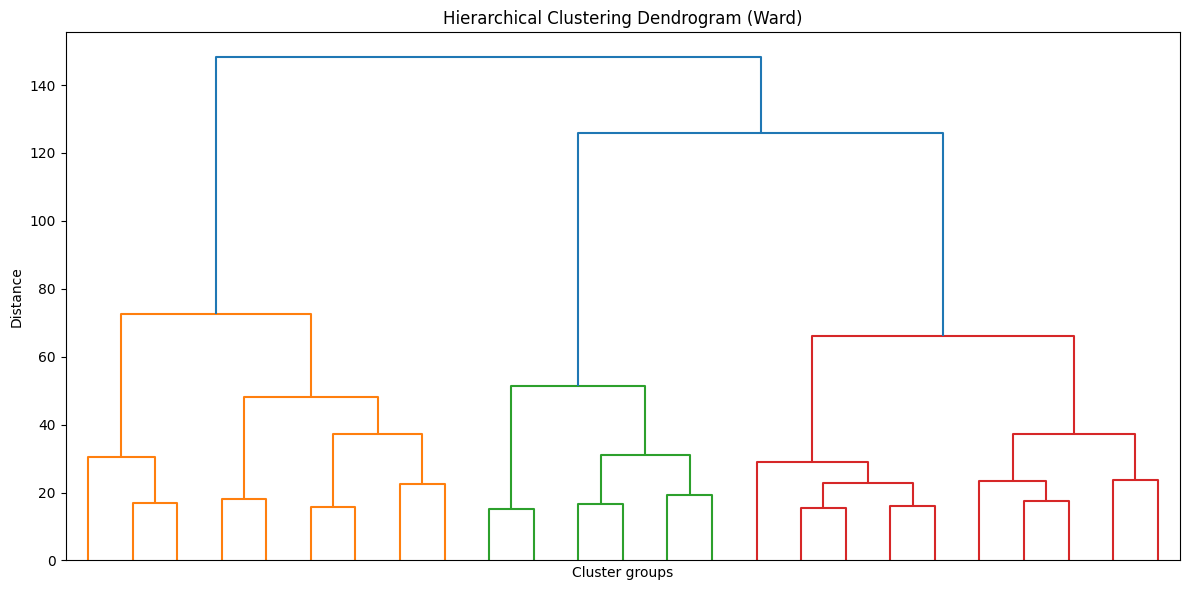

In [68]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler

features = ['feeding_intensity', 'feeding_variety', 'feeding_consistency']

X = site_period[features].dropna()
X_scaled = StandardScaler().fit_transform(X)

Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    truncate_mode='lastp',
    p=25,
    show_leaf_counts=False,
    no_labels=True
)

plt.title("Hierarchical Clustering Dendrogram (Ward)")
plt.ylabel("Distance")
plt.xlabel("Cluster groups")
plt.tight_layout()
plt.show()

In this section, I selected three behavioral variables, feeding intensity, feeding variety, and feeding consistency, from the site_period dataset and removed rows with missing values using .dropna(), because clustering methods require complete data in order to calculate distances properly. I then applied StandardScaler().fit_transform(X) to standardize the variables. This transformation converts each feature into a z-score with mean zero and standard deviation one. I did this because clustering is based on distance calculations, and if the variables are on different scales, the one with larger values would have more influence on the result. By standardizing them, I made sure that each behavioral variable contributes equally to the clustering process.

After preparing the data, I used linkage(X_scaled, method='ward') to perform hierarchical clustering with Ward’s method. Ward’s method merges observations step by step while trying to keep the variation within each cluster as small as possible. I then visualized the results using a dendrogram. Since the dataset is relatively large, I truncated the dendrogram to show only the last 25 merged clusters to make the plot easier to read. I also removed labels and leaf counts to reduce visual clutter. By looking at how the clusters merge at different distance levels, I was able to observe the overall grouping structure and identify possible breakpoints for choosing an appropriate number of clusters.

In [69]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster

features = ['feeding_intensity', 'feeding_variety', 'feeding_consistency']
X = site_period[features].dropna()
X_scaled = StandardScaler().fit_transform(X)

Z = linkage(X_scaled, method='ward')
k = 5
hc_labels = fcluster(Z, t=k, criterion='maxclust')

site_period.loc[X.index, 'cluster_hc'] = hc_labels
print("Cluster counts for Hierarchical Clustering:")
display(site_period['cluster_hc'].value_counts())

Cluster counts for Hierarchical Clustering:


cluster_hc
3.0    4642
1.0    2586
2.0    1571
5.0    1381
4.0    1001
Name: count, dtype: int64

In this step, I applied hierarchical clustering using Ward’s method on the standardized feeding behavior features. After computing the linkage matrix Z with linkage(X_scaled, method='ward'), I set k = 5 and used fcluster(Z, t=k, criterion='maxclust') to divide the dendrogram into five groups. The maxclust criterion cuts the tree so that it produces no more than five clusters. I then assigned the resulting cluster labels to a new column called cluster_hc in the original dataset. After that, I calculated and displayed the number of observations in each cluster to check whether the groups were reasonably balanced and meaningful for further analysis.

I chose k = 5 based on the dendrogram structure. In the plot, there were clear gaps in the vertical distance between some merging steps, which suggested possible natural separation points. Selecting five clusters allows me to capture differences in feeding behavior while still keeping the results interpretable and manageable.

##(4)KMeans Clustering and Elbow Method Selection （Yiheng）

In [70]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

for k in [2, 3, 4, 5, 6, 7, 8]:
    labels = KMeans(k, random_state=42).fit_predict(X_scaled)
    print(k, silhouette_score(X_scaled, labels))

2 0.3568429856354104
3 0.42921705717651604
4 0.3998776542883344
5 0.4063763110817488
6 0.38682899231966844
7 0.37787979922170317
8 0.3844273825591094


In this step, I tested different numbers of clusters, from 2 to 8, using the silhouette score to find the most suitable value of k for KMeans. For each k, I ran the KMeans algorithm on the standardized feature matrix and calculated the silhouette score, which evaluates how well each observation fits within its assigned cluster compared to other clusters. The score ranges from -1 to 1, and higher values mean the clusters are more clearly separated and internally consistent. Based on the results, k = 3 gave the highest silhouette score, which suggests that dividing the data into three clusters provides the most clear and meaningful grouping of feeding behavior patterns.

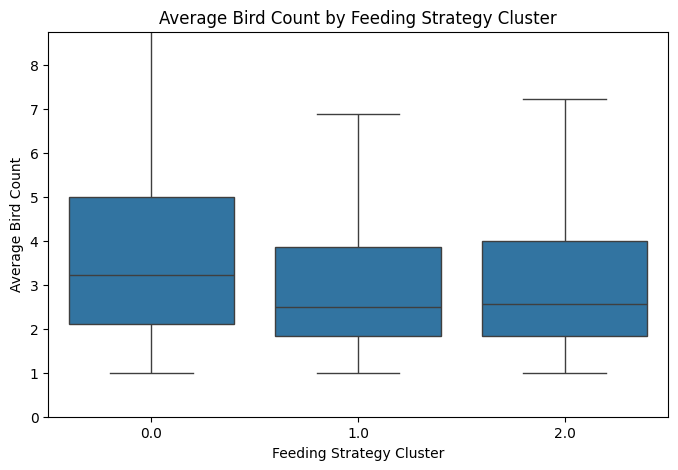

In [71]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

features = ['feeding_intensity', 'feeding_variety', 'feeding_consistency']
X = site_period[features].dropna()
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
site_period.loc[X.index, 'cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=site_period,
    x='cluster',
    y='avg_bird_count',
    showfliers=False
)

plt.ylim(0, site_period['avg_bird_count'].quantile(0.95))
plt.title("Average Bird Count by Feeding Strategy Cluster")
plt.xlabel("Feeding Strategy Cluster")
plt.ylabel("Average Bird Count")
plt.show()

In this part, I used KMeans clustering to group the data based on three behavioral features, which are feeding intensity, feeding variety, and feeding consistency. First, I selected these three columns from the site_period dataset and removed any rows with missing values using .dropna(), since KMeans cannot handle missing data. Then, I applied StandardScaler().fit_transform(X) to standardize the variables. This step converts each feature into a standardized form with mean zero and standard deviation one. I did this because KMeans relies on distance calculations, and if the variables are on different scales, the feature with larger values would have more influence on the clustering result.

After preparing the data, I created the KMeans model with n_clusters=3 and set random_state=42 to make the results reproducible. I then used fit_predict(X_scaled) to both train the model and assign cluster labels to each observation. These cluster labels were stored in a new column called cluster in the original dataset so that I could use them later for comparison and further analysis. Finally, I created a boxplot using Seaborn to visualize how the outcome variable avg_bird_count differs across the three clusters, and I adjusted the y-axis limit to reduce the effect of extreme values for clearer presentation.

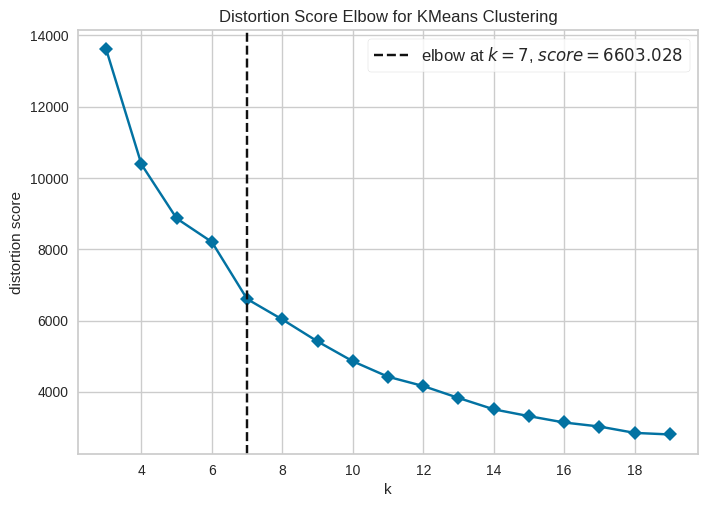

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

features = ['feeding_intensity', 'feeding_variety', 'feeding_consistency']

X = site_period[features].dropna()
X_scaled = StandardScaler().fit_transform(X)

model = KMeans(random_state=60)
viz = KElbowVisualizer(
    model,
    k=(3, 20),
    metric='distortion',
    timings=False
)

viz.fit(X_scaled)
viz.show()

In this part, I used the Elbow method to help decide the appropriate number of clusters for KMeans. First, I selected the three feeding behavior variables and removed missing values. Then I standardized the data using StandardScaler so that each feature has mean zero and standard deviation one. This is important because KMeans is based on distance, and variables with larger scales could otherwise dominate the results.

After that, I created a KMeans model and set a random state to make the results reproducible. I then used KElbowVisualizer from Yellowbrick to test different numbers of clusters. I set the range of k from 3 to 20 and chose distortion as the evaluation metric, which represents the within cluster sum of squared distances. The visualizer fits the model on the scaled data and plots how distortion changes as k increases. Finally, I called viz.show() to display the elbow plot. By looking at the point where the curve starts to flatten, I can choose a reasonable number of clusters for the final model.

#(5)Association rules analysis for Co-occurance species (Hanchao)

##Association Rule
Based on the EDA of Co-occurance matrix, we only limit to finding co-occurance pattern of species in the same site, while neglecting on time limit(which months and years they appear) as well as nearby sites(Grouping behavior of species in a region of nearby sites).

Instead of using sub_id (unique identifier for checklist) for individual to find cooccurance pattern between birds. Forming pair of sites network within a specific distance would be an more ideal approach. Then, we will use Association rule to identify patterns within range of location.

The raw table implies three levels:
* site: LOC_ID, LATITUDE, LONGITUDE, SUBNATIONAL1_CODE, etc.
* checklist: SUB_ID, LOC_ID, YEAR, MONTH, etc.
* observation: OBS_ID, SUB_ID, SPECIES_CODE, HOW_MANY, VALID, REVIEWED

We will be using a "Site-Month" method. Each individual row would be one site of particular month since grouping behaviors cannot be identified from birds of different month.

Next, we will be setting up the following hyperparameters:
* Distance threshold: X_km
  * (e.g., 5, 10, 25, 50 km)
  * This defines which sites are “nearby.”
* max_neighbors = k (cap per site), e.g., 20
  * Neighbor rule prevents dense regions from dominating.
* USE_STRICT_MONTH = True
  * This means that only co-occurance pattern of the same momth would be counted.
* FILTER VALID
  * Controls whether to filter invalid checklists from the dataset
* MIN_COOCCUR_EDGES = 30       
  * stability filter for pairwise results
* MIN_UNIT_SUPPORT = 20        
  * drop very-rare species across site-month units
* TOP_PAIRS_TO_SHOW = 30
  * shows the highest lifts of the top 30 pairs
* TOP_NETWORK_EDGES = 150      
  * number of edges to show in network plot

 ## Initialize Hyperparameter

In [73]:
df_pfw = pd.read_csv('/content/PFW_2021_public.csv')


import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import networkx as nx

# -----------------------
# Hyperparameters (yours)
# -----------------------
X_KM = 10
MAX_NEIGHBORS = 20
USE_STRICT_MONTH = True  # this code uses strict (Year, Month)

# Additional recommended knobs
FILTER_VALID = True
FILTER_REVIEWED = False
MIN_COOCCUR_EDGES = 30       # stability filter for pairwise results
MIN_UNIT_SUPPORT = 20        # drop very-rare species across site-month units
TOP_PAIRS_TO_SHOW = 30
TOP_NETWORK_EDGES = 150      # number of edges to show in network plot

## Preproccessing Features

In [74]:
# -----------------------
# 0) Input dataframe
# -----------------------
# Expect df_pfw exists in your notebook.
# Columns used (case-sensitive): you said you have Year/Month/PROJ_PERIOD_ID.
cols_needed = [
    "loc_id","latitude","longitude","subnational1_code","entry_technique",
    "sub_id","obs_id","Year","Month","Day","PROJ_PERIOD_ID",
    "species_code","how_many","valid","reviewed",
    "day1_am","day1_pm","day2_am","day2_pm",
    "effort_hrs_atleast","snow_dep_atleast"
]
df = df_pfw[cols_needed].copy()

# Type cleanup
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")
df["Month"] = pd.to_numeric(df["Month"], errors="coerce").astype("Int64")
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
df["how_many"] = pd.to_numeric(df["how_many"], errors="coerce")

# Drop rows missing site-month essentials
df = df.dropna(subset=["loc_id", "Year", "Month", "latitude", "longitude"])

# Validity filtering (observation-level)
if FILTER_VALID and "valid" in df.columns:
    df = df[df["valid"] == 1]
if FILTER_REVIEWED and "reviewed" in df.columns:
    df = df[df["reviewed"] == 1]

# -----------------------
# Helper: mode function
# -----------------------
def mode_or_nan(s: pd.Series):
    s = s.dropna()
    if len(s) == 0:
        return np.nan
    return s.mode().iloc[0]

## Transform dataframe for Association Rule analysis
* Create a dataframe of site-month checklist information where unit_id is defined by loc_id_year_month
* Create a dataframe of combinations of each site-month checklist and each species
  * "present" = whether species occur in this site-month checklist
  * "n_checklist_with_species" = number of checklists for that site-month that such species occur

In [75]:
# -----------------------
# 1) Build df_checklists (1 row per sub_id)
# -----------------------
df_checklists = (
    df[[
        "loc_id","Year","Month","sub_id",
        "latitude","longitude","subnational1_code","entry_technique",
        "day1_am","day1_pm","day2_am","day2_pm",
        "effort_hrs_atleast","snow_dep_atleast","PROJ_PERIOD_ID"
    ]]
    .drop_duplicates(subset=["sub_id"])
    .copy()
)

# Site-month unit id
df_checklists["unit_id"] = (
    df_checklists["loc_id"].astype(str) + "_" +
    df_checklists["Year"].astype(int).astype(str) + "_" +
    df_checklists["Month"].astype(int).astype(str).str.zfill(2)
)

# -----------------------
# 2) Build df_units (site-month table)
# -----------------------
df_units = (
    df_checklists
    .groupby(["loc_id","Year","Month","unit_id"], as_index=False)
    .agg(
        latitude=("latitude","first"),
        longitude=("longitude","first"),
        subnational1_code=("subnational1_code","first"),
        entry_technique=("entry_technique","first"),
        PROJ_PERIOD_ID=("PROJ_PERIOD_ID","first"),
        n_checklists=("sub_id","nunique"),
        day1_am_rate=("day1_am","mean"),
        day1_pm_rate=("day1_pm","mean"),
        day2_am_rate=("day2_am","mean"),
        day2_pm_rate=("day2_pm","mean"),
        effort_mode=("effort_hrs_atleast", mode_or_nan),
        snow_mode=("snow_dep_atleast", mode_or_nan),
    )
)

# -----------------------
# 3) Build df_site_month_species (site-month × species)
# -----------------------
df["unit_id"] = (
    df["loc_id"].astype(str) + "_" +
    df["Year"].astype(int).astype(str) + "_" +
    df["Month"].astype(int).astype(str).str.zfill(2)
)

df_site_month_species = (
    df.dropna(subset=["species_code"])
    .groupby(["loc_id","Year","Month","unit_id","species_code"], as_index=False)
    .agg(
        present=("obs_id", lambda x: 1),
        n_checklists_with_species=("sub_id", "nunique"),
        max_how_many=("how_many", "max"),
        mean_how_many=("how_many", "mean"),
    )
)

# Keep only units that have at least one species record
units_with_species = set(df_site_month_species["unit_id"].unique())
df_units = df_units[df_units["unit_id"].isin(units_with_species)].copy()

print(df_units.head())
print(df_site_month_species.head())

    loc_id  Year  Month          unit_id   latitude  longitude subnational1_code  entry_technique PROJ_PERIOD_ID  n_checklists  day1_am_rate  day1_pm_rate  day2_am_rate  day2_pm_rate  effort_mode  \
0  L100032  2020     11  L100032_2020_11  45.132361 -93.130328             US-MN  PointMaker1.0_2       PFW_2021             2           1.0           1.0           1.0           1.0        1.001   
1  L100032  2021      1  L100032_2021_01  45.132361 -93.130328             US-MN  PointMaker1.0_2       PFW_2021             1           1.0           1.0           1.0           1.0        1.001   
2  L100032  2021      2  L100032_2021_02  45.132361 -93.130328             US-MN  PointMaker1.0_2       PFW_2021             1           1.0           1.0           1.0           1.0        1.001   
3  L100032  2021      3  L100032_2021_03  45.132361 -93.130328             US-MN  PointMaker1.0_2       PFW_2021             1           1.0           1.0           1.0           1.0        1.001   
4  L1

## Filtering Rare Species based on hyperparameter

In [76]:
# 4) Optional: filter rare species (reduces noise)
# -----------------------
species_unit_support = (
    df_site_month_species.groupby("species_code")["unit_id"].nunique()
)
keep_species = species_unit_support[species_unit_support >= MIN_UNIT_SUPPORT].index
df_site_month_species = df_site_month_species[df_site_month_species["species_code"].isin(keep_species)].copy()

# Recompute units_with_species after species filtering
units_with_species = set(df_site_month_species["unit_id"].unique())
df_units = df_units[df_units["unit_id"].isin(units_with_species)].copy()

print("df_units rows (site-month):", len(df_units))
print("unique loc_id:", df_units["loc_id"].nunique())
print("df_site_month_species rows:", len(df_site_month_species))
print("unique species kept:", df_site_month_species["species_code"].nunique())


df_units rows (site-month): 50081
unique loc_id: 15253
df_site_month_species rows: 94767
unique species kept: 128


## Build "Market Basket" of species of neary_by_sites
* Build dataframe of nearby sites
  * Create a sets of pair_of_sites that are x km within each other, limited to the max_neighbor role
  * The algorithm make sures no repetitive pair_of_sites in the dataframe
* Build dataframe of co-occur species from pair_of_sites

In [77]:
# -----------------------
# 5) Build species sets per unit_id (for transactions)
# -----------------------
species_by_unit = (
    df_site_month_species[df_site_month_species["present"] == 1]
    .groupby("unit_id")["species_code"]
    .apply(set)
    .to_dict()
)

# -----------------------
# 6) Build spatial neighbor edges within each (Year, Month)
# -----------------------
def build_edges_one_month(df_m: pd.DataFrame, x_km: float, max_neighbors: int):
    """
    df_m: units for one (Year, Month), indexed by unit_id with columns latitude/longitude
    returns: list of (unit_u, unit_v, dist_km) with each pair once
    """
    df_m = df_m.dropna(subset=["latitude","longitude"])
    if len(df_m) < 2:
        return []

    coords = np.radians(df_m[["latitude","longitude"]].to_numpy())
    tree = BallTree(coords, metric="haversine")

    k = min(max_neighbors + 1, len(df_m))  # +1 includes self
    dist_rad, idx = tree.query(coords, k=k)

    radius_rad = x_km / 6371.0
    unit_ids = df_m.index.to_numpy()

    edges = []
    for i in range(len(df_m)):
        for d, j in zip(dist_rad[i], idx[i]):
            if j <= i:
                continue
            if d <= radius_rad:
                edges.append((unit_ids[i], unit_ids[j], float(d * 6371.0)))
    return edges

units = df_units.set_index("unit_id")[["loc_id","Year","Month","latitude","longitude","subnational1_code"]].copy()

edges_all = []
for (yy, mm), df_m in units.groupby(["Year","Month"]):
    if len(df_m) < 2:
        continue
    edges = build_edges_one_month(df_m, x_km=X_KM, max_neighbors=MAX_NEIGHBORS)
    for u, v, d in edges:
        # keep only edges where at least one side has species after filtering
        if (u in species_by_unit) or (v in species_by_unit):
            edges_all.append((int(yy), int(mm), u, v, d))

edges_df = pd.DataFrame(edges_all, columns=["Year","Month","unit_u","unit_v","dist_km"])
print("Total spatial edges:", len(edges_df))
print(edges_df.head())

# -----------------------
# 7) Build edge transactions (UNION of species sets)
# -----------------------
def edge_union_transaction(u, v):
    return species_by_unit.get(u, set()) | species_by_unit.get(v, set())

edge_transactions = []
for r in edges_df.itertuples(index=False):
    trans = edge_union_transaction(r.unit_u, r.unit_v)
    if len(trans) > 0:
        edge_transactions.append(trans)

print("Edges with non-empty transactions:", len(edge_transactions))

Total spatial edges: 135007
   Year  Month           unit_u             unit_v   dist_km
0  2020     11  L100032_2020_11  L12725934_2020_11  4.624820
1  2020     11  L100032_2020_11   L5185145_2020_11  4.911144
2  2020     11  L100032_2020_11  L12489354_2020_11  6.304110
3  2020     11  L100032_2020_11    L138614_2020_11  6.550582
4  2020     11  L100032_2020_11  L12575753_2020_11  6.816902
Edges with non-empty transactions: 135007


## Calculate the support and lift of each pair of species
* The results is shown for the top pairs(with the highest lift)
* Network graph showing species co-occurance pattern

Pairwise association rows: 1832


species_i species_j  cooccur_edges       p_i       p_j      p_ij       lift
1667   bkbmag1    harspa             30  0.005052  0.000526  0.000222  83.644005
1329    caltow    nutwoo             64  0.005207  0.002126  0.000474  42.825164
1695    balori    easpho             32  0.001941  0.003081  0.000237  39.637992
1493   blctit4    whwdov             36  0.001200  0.005785  0.000267  38.414284
891     labwoo    whwdov             34  0.001133  0.005785  0.000252  38.414284
1677   batpig1    caltow             43  0.002200  0.005207  0.000319  27.804364
164     caltow    oaktit             91  0.005207  0.004770  0.000674  27.136666
1051   batpig1    oaktit             34  0.002200  0.004770  0.000252  23.998986
958     orcwar    whwdov             68  0.003859  0.005785  0.000504  22.561940
1049   batpig1   cowscj1             82  0.002200  0.013288  0.000607  20.777402
1133    bushti    cantow             35  0.019429  0.000726  0.000259  18.382305
1808    lesgol    linspa             37  0.017288  0.000889  0.000274  17.835115
1622    calqua    eucdov             42  0.001741  0.010266  0.000311  17.409026
1714   batpig1    stejay             62  0.002200  0.012096  0.000459  17.258591
1330    gocspa    nutwoo             58  0.011873  0.002126  0.000430  17.020365
662     stejay    varthr            163  0.012096  0.005918  0.001207  16.865955
1328    bnhnut    pinwar            195  0.007763  0.011503  0.001444  16.175517
168     gocspa    oaktit            119  0.011873  0.004770  0.000881  15.562661
660     towwar    varthr             80  0.006637  0.005918  0.000593  15.086604
1484    lesgol    wesblu             42  0.017288  0.001222  0.000311  14.723830
1154    bnhnut    eastow            155  0.007763  0.010288  0.001148  14.375550
514     lesgol    oaktit            160  0.017288  0.004770  0.001185  14.371085
508    cowscj1    oaktit            119  0.013288  0.004770  0.000881  13.905767
1417    mouchi   wooscj2             33  0.007681  0.002311  0.000244  13.770093
480     caltow    lesgol            165  0.005207  0.017288  0.001222  13.576382
1762    balori    eastow             36  0.001941  0.010288  0.000267  13.355349
1191    bnhnut    easpho             42  0.007763  0.003081  0.000311  13.006216
1092    caltow   cowscj1            121  0.005207  0.013288  0.000896  12.952807
1107    eucdov    pygnut             32  0.010266  0.001792  0.000237  12.880350
1138    eucdov   wooscj2             41  0.010266  0.002311  0.000304  12.800364


TOP PAIRS:


species_i species_j  cooccur_edges       lift
1667   bkbmag1    harspa             30  83.644005
1329    caltow    nutwoo             64  42.825164
1695    balori    easpho             32  39.637992
1493   blctit4    whwdov             36  38.414284
891     labwoo    whwdov             34  38.414284
1677   batpig1    caltow             43  27.804364
164     caltow    oaktit             91  27.136666
1051   batpig1    oaktit             34  23.998986
958     orcwar    whwdov             68  22.561940
1049   batpig1   cowscj1             82  20.777402
1133    bushti    cantow             35  18.382305
1808    lesgol    linspa             37  17.835115
1622    calqua    eucdov             42  17.409026
1714   batpig1    stejay             62  17.258591
1330    gocspa    nutwoo             58  17.020365
662     stejay    varthr            163  16.865955
1328    bnhnut    pinwar            195  16.175517
168     gocspa    oaktit            119  15.562661
660     towwar    varthr             80  15.086604
1484    lesgol    wesblu             42  14.723830
1154    bnhnut    eastow            155  14.375550
514     lesgol    oaktit            160  14.371085
508    cowscj1    oaktit            119  13.905767
1417    mouchi   wooscj2             33  13.770093
480     caltow    lesgol            165  13.576382
1762    balori    eastow             36  13.355349
1191    bnhnut    easpho             42  13.006216
1092    caltow   cowscj1            121  12.952807
1107    eucdov    pygnut             32  12.880350
1138    eucdov   wooscj2             41  12.800364

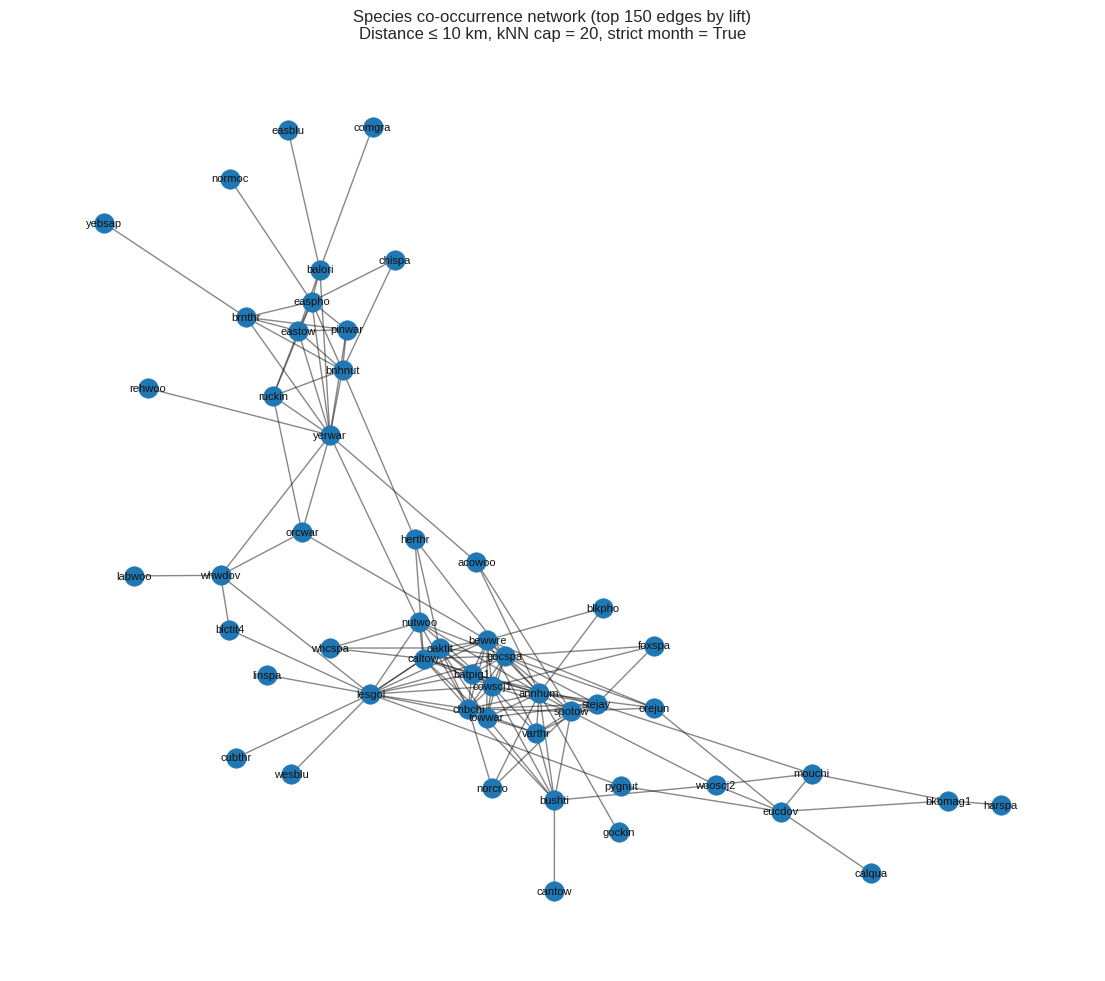

In [78]:
# -----------------------
# 8) Compute pairwise associations (lift) over edge-transactions
# -----------------------
count_s = Counter()
count_ij = Counter()
n_edges = 0

for trans in edge_transactions:
    n_edges += 1
    for s in trans:
        count_s[s] += 1
    for i, j in itertools.combinations(sorted(trans), 2):
        count_ij[(i, j)] += 1

rows = []
for (i, j), cij in count_ij.items():
    if cij < MIN_COOCCUR_EDGES:
        continue
    pi = count_s[i] / n_edges
    pj = count_s[j] / n_edges
    pij = cij / n_edges
    lift = pij / (pi * pj) if pi > 0 and pj > 0 else np.nan
    rows.append((i, j, cij, pi, pj, pij, lift))

pairs_df = pd.DataFrame(
    rows, columns=["species_i","species_j","cooccur_edges","p_i","p_j","p_ij","lift"]
).sort_values(["lift","cooccur_edges"], ascending=[False, False])

print("Pairwise association rows:", len(pairs_df))
display(pairs_df.head(TOP_PAIRS_TO_SHOW))

# -----------------------
# 9) Show results (table + network plot)
# -----------------------

# 9a) Top pairs table
top_pairs = pairs_df[["species_i","species_j","cooccur_edges","lift"]].head(TOP_PAIRS_TO_SHOW)
print("\nTOP PAIRS:")
display(top_pairs)

# 9b) Network graph of top edges by lift
plot_df = pairs_df.head(TOP_NETWORK_EDGES).copy()

G = nx.Graph()
for r in plot_df.itertuples(index=False):
    G.add_edge(r.species_i, r.species_j, weight=float(r.lift), cooccur=int(r.cooccur_edges))

plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, seed=42, k=None)

nx.draw_networkx_nodes(G, pos, node_size=200)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title(f"Species co-occurrence network (top {TOP_NETWORK_EDGES} edges by lift)\n"
          f"Distance ≤ {X_KM} km, kNN cap = {MAX_NEIGHBORS}, strict month = {USE_STRICT_MONTH}")
plt.axis("off")
plt.show()



#(6) The impact of feeding behavior on bird abundance and diversity（Liyang）

In [79]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Load data
# Read two CSV files: observation data (PFW_OBS_clean.csv) and site information (PFW_SITE_clean.csv)
obs = pd.read_csv("/content/PFW_OBS_clean.csv")
site = pd.read_csv("/content/PFW_SITE_clean.csv")

# Remove leading/trailing spaces from column names and convert to lowercase
# to avoid case inconsistency issues in subsequent processing
obs.columns = obs.columns.str.strip().str.lower()
site.columns = site.columns.str.strip().str.lower()

# Convert timestamp column to pandas datetime type; invalid values become NaT (Not a Time)
obs["timestamp"] = pd.to_datetime(obs["timestamp"], errors="coerce")

# 2. Calculate metrics for each checklist
# Group by sub_id, loc_id, proj_period_id, timestamp (each observation corresponds to a checklist)
# as_index=False keeps group keys as columns rather than index
g = obs.groupby(["sub_id", "loc_id", "proj_period_id", "timestamp"], as_index=False)

# Aggregate calculations for each group:
#   - effort_h: take the first valid observation duration (effort_hrs_atleast) as checklist effort
#   - birds: sum of all bird counts in the checklist
#   - species: number of unique species codes in the checklist (species richness)
ck = g.agg(
    effort_h=("effort_hrs_atleast", "mean"),
    birds=("how_many", "sum"),
    species=("species_code", "nunique")
)

# Keep only records with observation duration > 0 to avoid division by zero
ck = ck[(ck["effort_h"] > 0)]

# Calculate birds per hour (bird abundance) and species per hour (species richness per hour)
ck["birds_per_hour"] = ck["birds"] / ck["effort_h"]
ck["species_per_hour"] = ck["species"] / ck["effort_h"]

# 3. Calculate Shannon diversity index for each checklist
# Group by sub_id and species_code, sum the total count of each species in each checklist
s = obs.groupby(["sub_id", "species_code"])["how_many"].sum().reset_index()

# Calculate relative abundance for each species in the checklist
# (p = species count / total birds in that checklist)
s["p"] = s["how_many"] / s.groupby("sub_id")["how_many"].transform("sum")

# For each checklist, calculate Shannon diversity index: -Σ(p * ln(p))
# Ignore NaN (when p=0, 0*ln(0) is defined as 0)
# Convert the result (a Series with sub_id as index and Shannon index as value) to DataFrame
sh = s.groupby("sub_id")["p"].apply(lambda x: -(x * np.log(x)).sum()).reset_index(name="shannon")

# Merge Shannon index into main dataframe ck using sub_id as key, left join
# For checklists with no species (e.g., no birds observed), fill Shannon index with 0
ck = ck.merge(sh, on="sub_id", how="left").fillna({"shannon": 0})

# Extract month (year-month) from timestamp for subsequent monthly aggregation
ck["month"] = ck["timestamp"].dt.to_period("M")

# 4. Calculate monthly averages for each metric
# Group by month, calculate mean of birds_per_hour, species_per_hour, and shannon
monthly = ck.groupby("month")[["birds_per_hour", "species_per_hour", "shannon"]].mean()

# 5. Define feeder-intensive site clustering
# Select feeding-related variables
feed_cols = [c for c in site.columns if c.startswith("fed_") or c.startswith("numfeeders_")]

X = site[feed_cols].fillna(0)

# Standardize features
X_scaled = StandardScaler().fit_transform(X)

# KMeans unsupervised learning
kmeans = KMeans(
    n_clusters=2,
    random_state=42,
    n_init=10
)
site["cluster"] = kmeans.fit_predict(X_scaled)

# 6. Merge site clustering information with checklist data
# Ensure data types of merge keys (loc_id, proj_period_id) are consistent to avoid merge failures
ck["loc_id"] = ck["loc_id"].astype(str)
site["loc_id"] = site["loc_id"].astype(str)
ck["proj_period_id"] = ck["proj_period_id"].astype(str)
site["proj_period_id"] = site["proj_period_id"].astype(str)

# Left join: merge site cluster labels into checklist data using loc_id and proj_period_id as keys
# Then remove checklists without site information
ck2 = ck.merge(site[["loc_id", "proj_period_id", "cluster"]],
               on=["loc_id", "proj_period_id"], how="left").dropna(subset=["cluster"])

# 7. First calculation of average metrics by cluster
# Group by current cluster, calculate mean of each metric to determine which cluster
# has higher birds_per_hour
cluster_compare = ck2.groupby("cluster")[["birds_per_hour", "species_per_hour", "shannon"]].mean()

# 8. Automatically relabel clusters: ensure cluster=1 always corresponds to the group with higher birds_per_hour
# Find the cluster number (0 or 1) with higher mean birds_per_hour
higher = cluster_compare["birds_per_hour"].idxmax()
# Reassign cluster column in ck2: rows originally in the higher group become 1, others become 0
# This ensures cluster=1 represents feeder-intensive sites (since feeder density should lead to higher bird abundance)
ck2["cluster"] = (ck2["cluster"] == higher).astype(int)

# 9. Recalculate cluster comparison (now cluster=1 is definitely the group with higher bird abundance)
cluster_compare = ck2.groupby("cluster")[["birds_per_hour", "species_per_hour", "shannon"]].mean()

# 10. Output results
print("Monthly trends")
print(monthly)

print("\nCluster comparison (cluster=1 = higher birds/hr, i.e., feeder-intensive)")
print(cluster_compare)

Monthly trends
         birds_per_hour  species_per_hour   shannon
month                                              
2020-11      410.383336        138.101753  0.115935
2020-12      519.681121        150.975292  0.119849
2021-01      565.399775        150.025341  0.119677
2021-02      499.325627        141.426473  0.129290
2021-03      472.554788        158.404915  0.130381
2021-04      378.142828        156.457750  0.147889

Cluster comparison (cluster=1 = higher birds/hr, i.e., feeder-intensive)
         birds_per_hour  species_per_hour   shannon
cluster                                            
0            478.573612        143.884382  0.127686
1            566.498721        197.530701  0.103438


Visualization

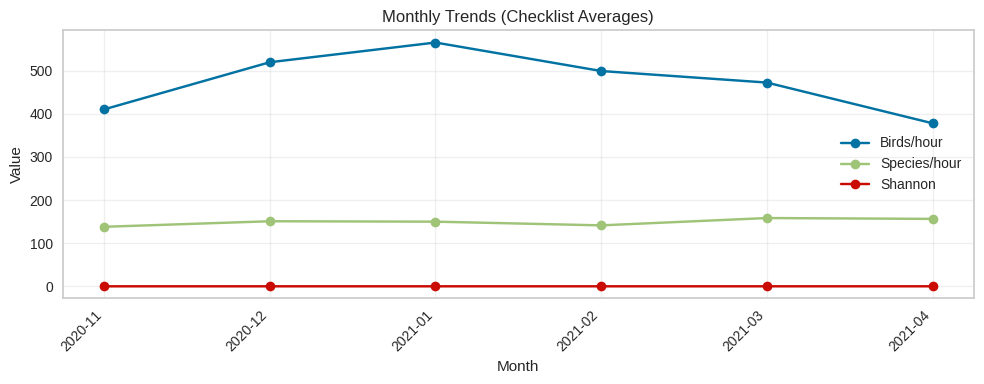

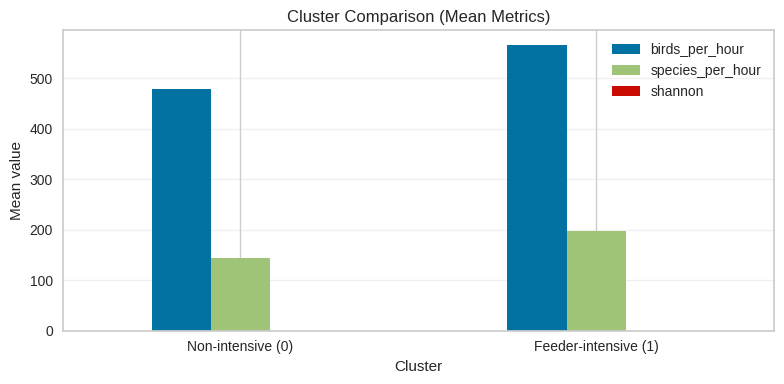

In [80]:
import matplotlib.pyplot as plt

monthly_plot = monthly.copy()
monthly_plot.index = monthly_plot.index.astype(str)

plt.figure(figsize=(10, 4))
plt.plot(monthly_plot.index, monthly_plot["birds_per_hour"], marker="o", label="Birds/hour")
plt.plot(monthly_plot.index, monthly_plot["species_per_hour"], marker="o", label="Species/hour")
plt.plot(monthly_plot.index, monthly_plot["shannon"], marker="o", label="Shannon")
plt.title("Monthly Trends (Checklist Averages)")
plt.xlabel("Month")
plt.ylabel("Value")
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


cluster_means = ck2.groupby("cluster")[["birds_per_hour", "species_per_hour", "shannon"]].mean()
cluster_means.index = ["Non-intensive (0)", "Feeder-intensive (1)"]

ax = cluster_means.plot(kind="bar", figsize=(8, 4))
ax.set_title("Cluster Comparison (Mean Metrics)")
ax.set_xlabel("Cluster")
ax.set_ylabel("Mean value")
ax.grid(True, axis="y", alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
